# Проект по моделям машинного обучения с учителем (supervised learning) - Методы на основе деревьев

---
---

## ЦЕЛЬ: Создать модель предсказания того, уйдёт ли абонент в отток (churn).

----
----

## Часть 0: Импортируем библиотеки и загружаем данные

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df = pd.read_csv('../DATA/Telco-Customer-Churn.csv')

In [6]:
df.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   
3         Yes          No              No        One year               No   
4          No          No              No  Month-to-month              Yes   

               PaymentMethod MonthlyCharges  TotalCharges  Churn  
0           Electronic check          29.85         29.85     No  
1               Mailed check          56.95       1889.50     No  
2               Mailed check          53.85        108.15    Yes  
3  Bank transfer (automatic)          42.30       1840.75     No  
4           Electronic check          70.70        151.65    Yes  

[5 rows x 21 columns]

## Часть 1: Общие характеристики данных

**С помощью метода `.info()` проверим типы данных для колонок, а также есть ли отсутствующие значения в датафрейме.**

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   gender            7032 non-null   object 
 2   SeniorCitizen     7032 non-null   int64  
 3   Partner           7032 non-null   object 
 4   Dependents        7032 non-null   object 
 5   tenure            7032 non-null   int64  
 6   PhoneService      7032 non-null   object 
 7   MultipleLines     7032 non-null   object 
 8   InternetService   7032 non-null   object 
 9   OnlineSecurity    7032 non-null   object 
 10  OnlineBackup      7032 non-null   object 
 11  DeviceProtection  7032 non-null   object 
 12  TechSupport       7032 non-null   object 
 13  StreamingTV       7032 non-null   object 
 14  StreamingMovies   7032 non-null   object 
 15  Contract          7032 non-null   object 
 16  PaperlessBilling  7032 non-null   object 


**Выведем статистические метрики для числовых колонок с помощью `.describe()`.**

In [10]:
df.describe()

SeniorCitizen       tenure  MonthlyCharges  TotalCharges
count    7032.000000  7032.000000     7032.000000   7032.000000
mean        0.162400    32.421786       64.798208   2283.300441
std         0.368844    24.545260       30.085974   2266.771362
min         0.000000     1.000000       18.250000     18.800000
25%         0.000000     9.000000       35.587500    401.450000
50%         0.000000    29.000000       70.350000   1397.475000
75%         0.000000    55.000000       89.862500   3794.737500
max         1.000000    72.000000      118.750000   8684.800000

# Часть 2:  Исследование данных (Exploratory Data Analysis)

## Исследование признаков

**Проверим, что в этих данных нет отсутствующих значений - для этого выведем количество значений NaN отдельно для каждой колонки.**

In [12]:
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

**Построим график CountPlot для проверки сбалансированности значений колонки с классами (Churn).**

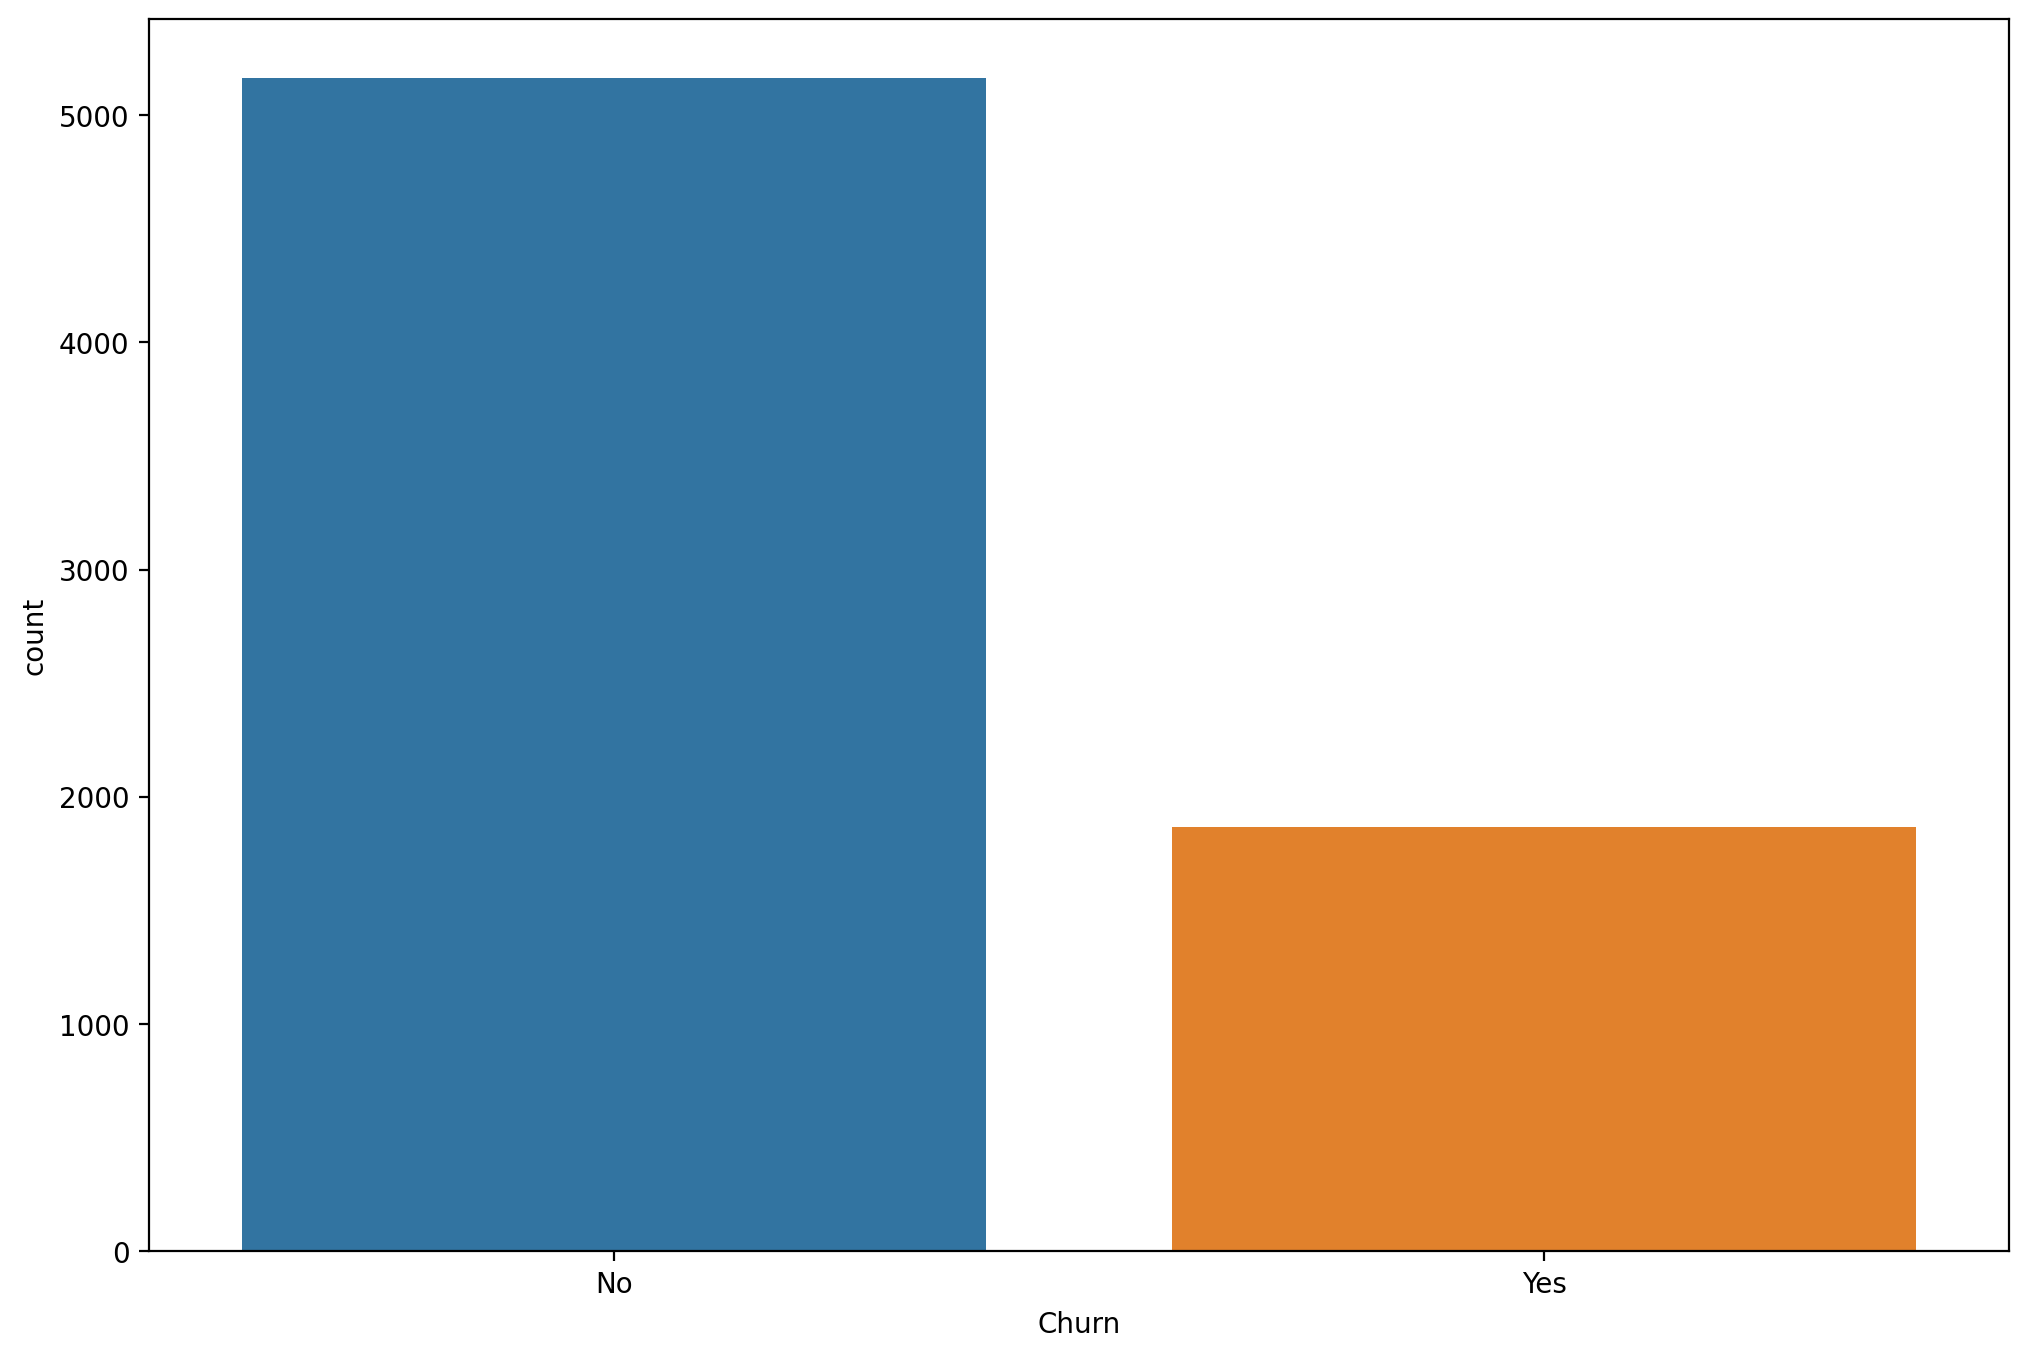

In [14]:
plt.figure(figsize=(12, 8), dpi=200)
sns.countplot(data=df, x='Churn', hue='Churn')
plt.show()

**Исследуем распределение колонки TotalCharges по различным категориям Churn с помощью графика Violin Plot.**

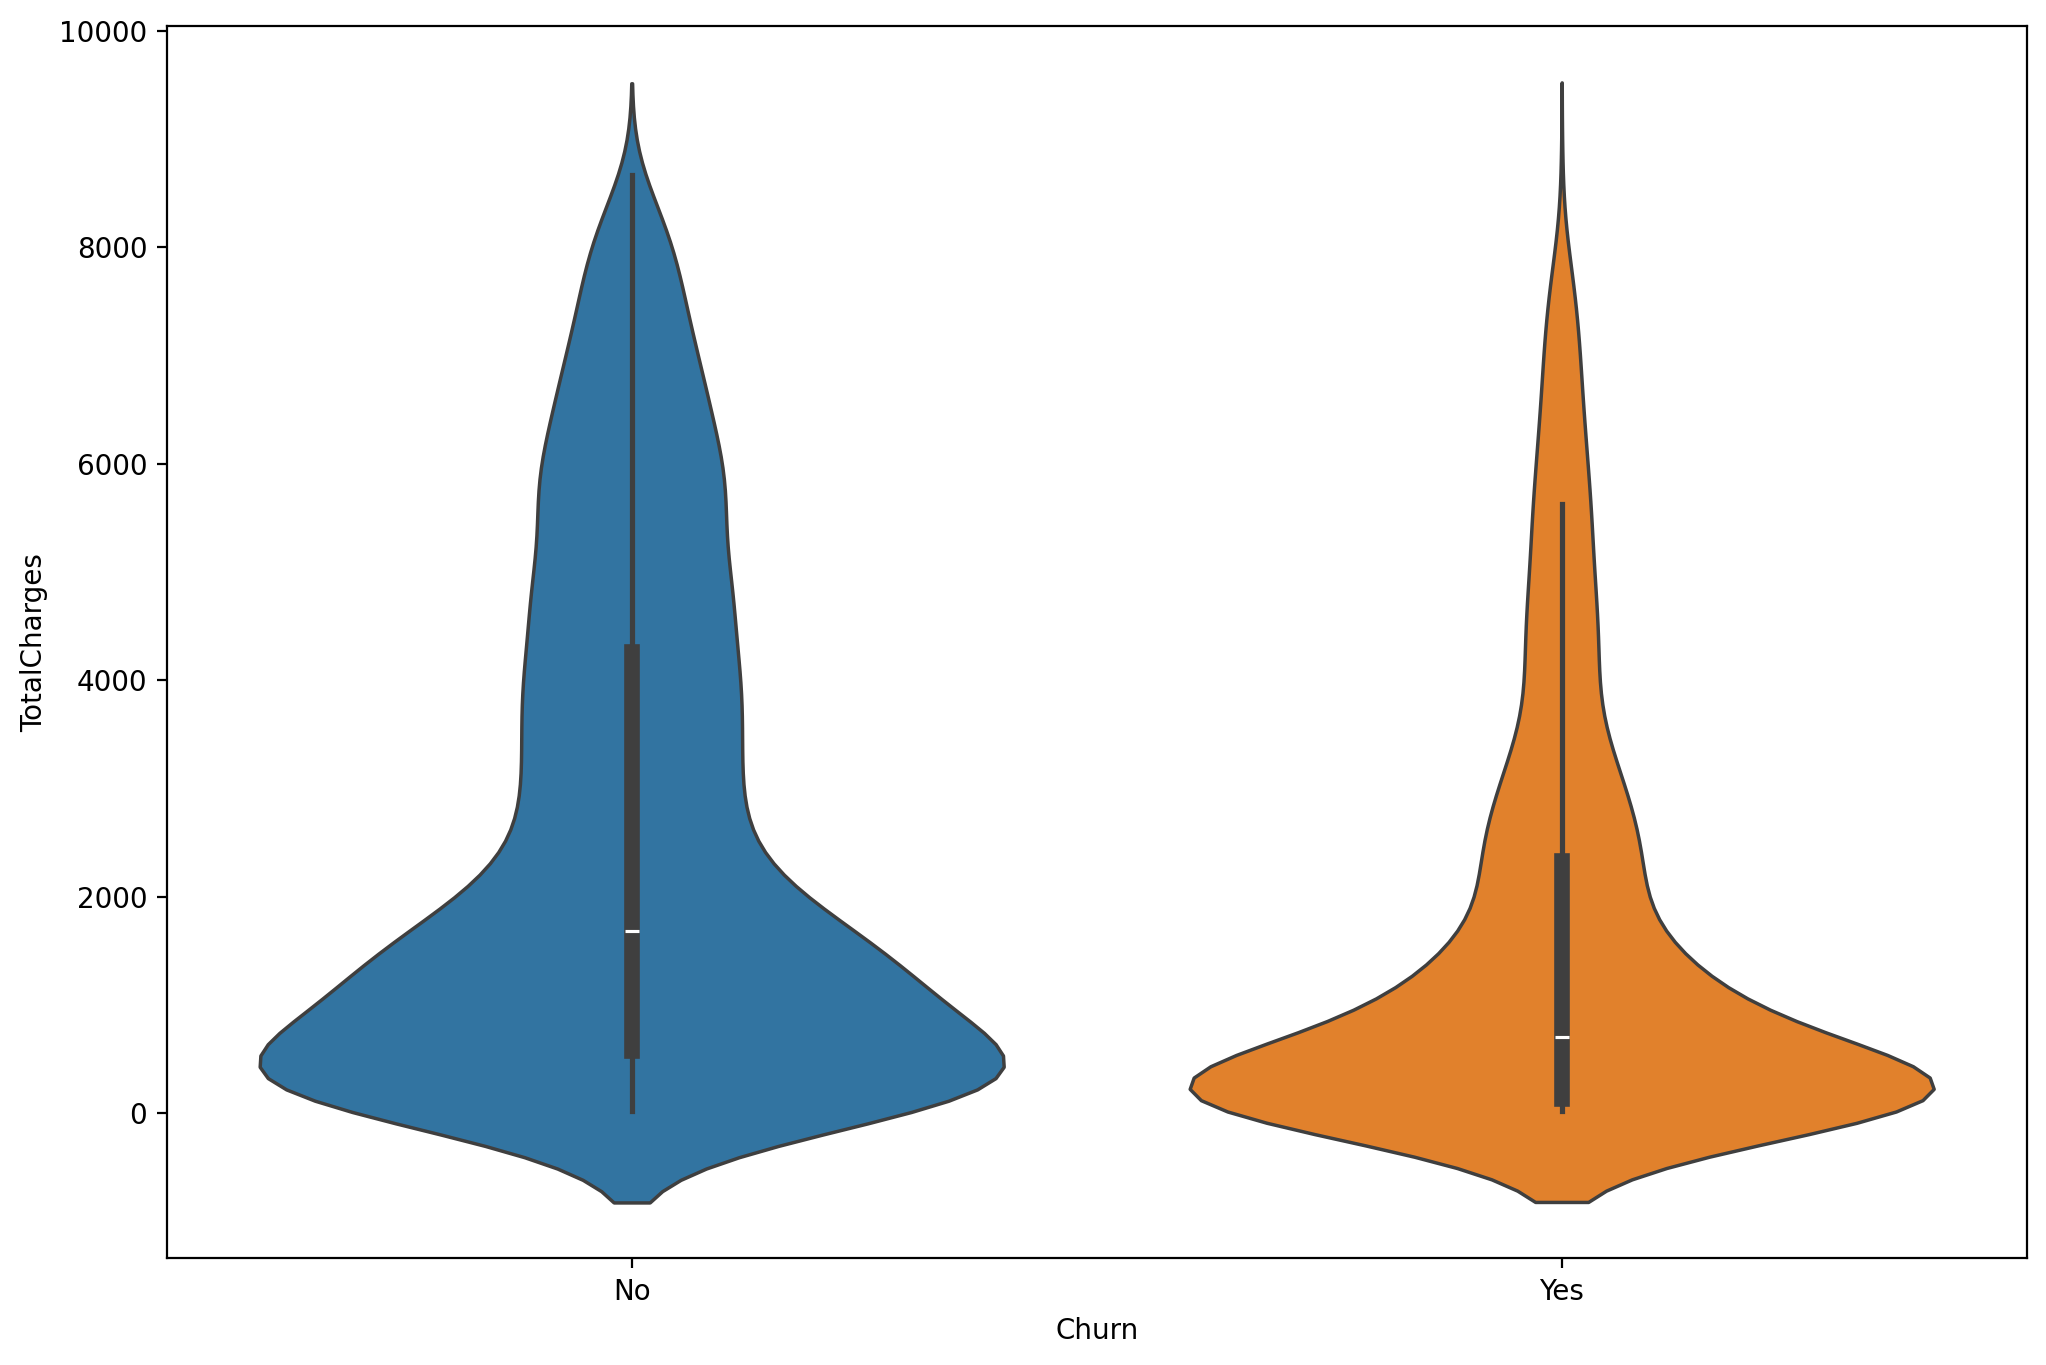

In [16]:
plt.figure(figsize=(12, 8), dpi=200)
sns.violinplot(data=df, x='Churn', y='TotalCharges', hue='Churn')
plt.show()

**Построим график boxplot с распределением колонки TotalCharges для различных типов контрактов, а также добавим раскраску цветами по колонке Churn.**

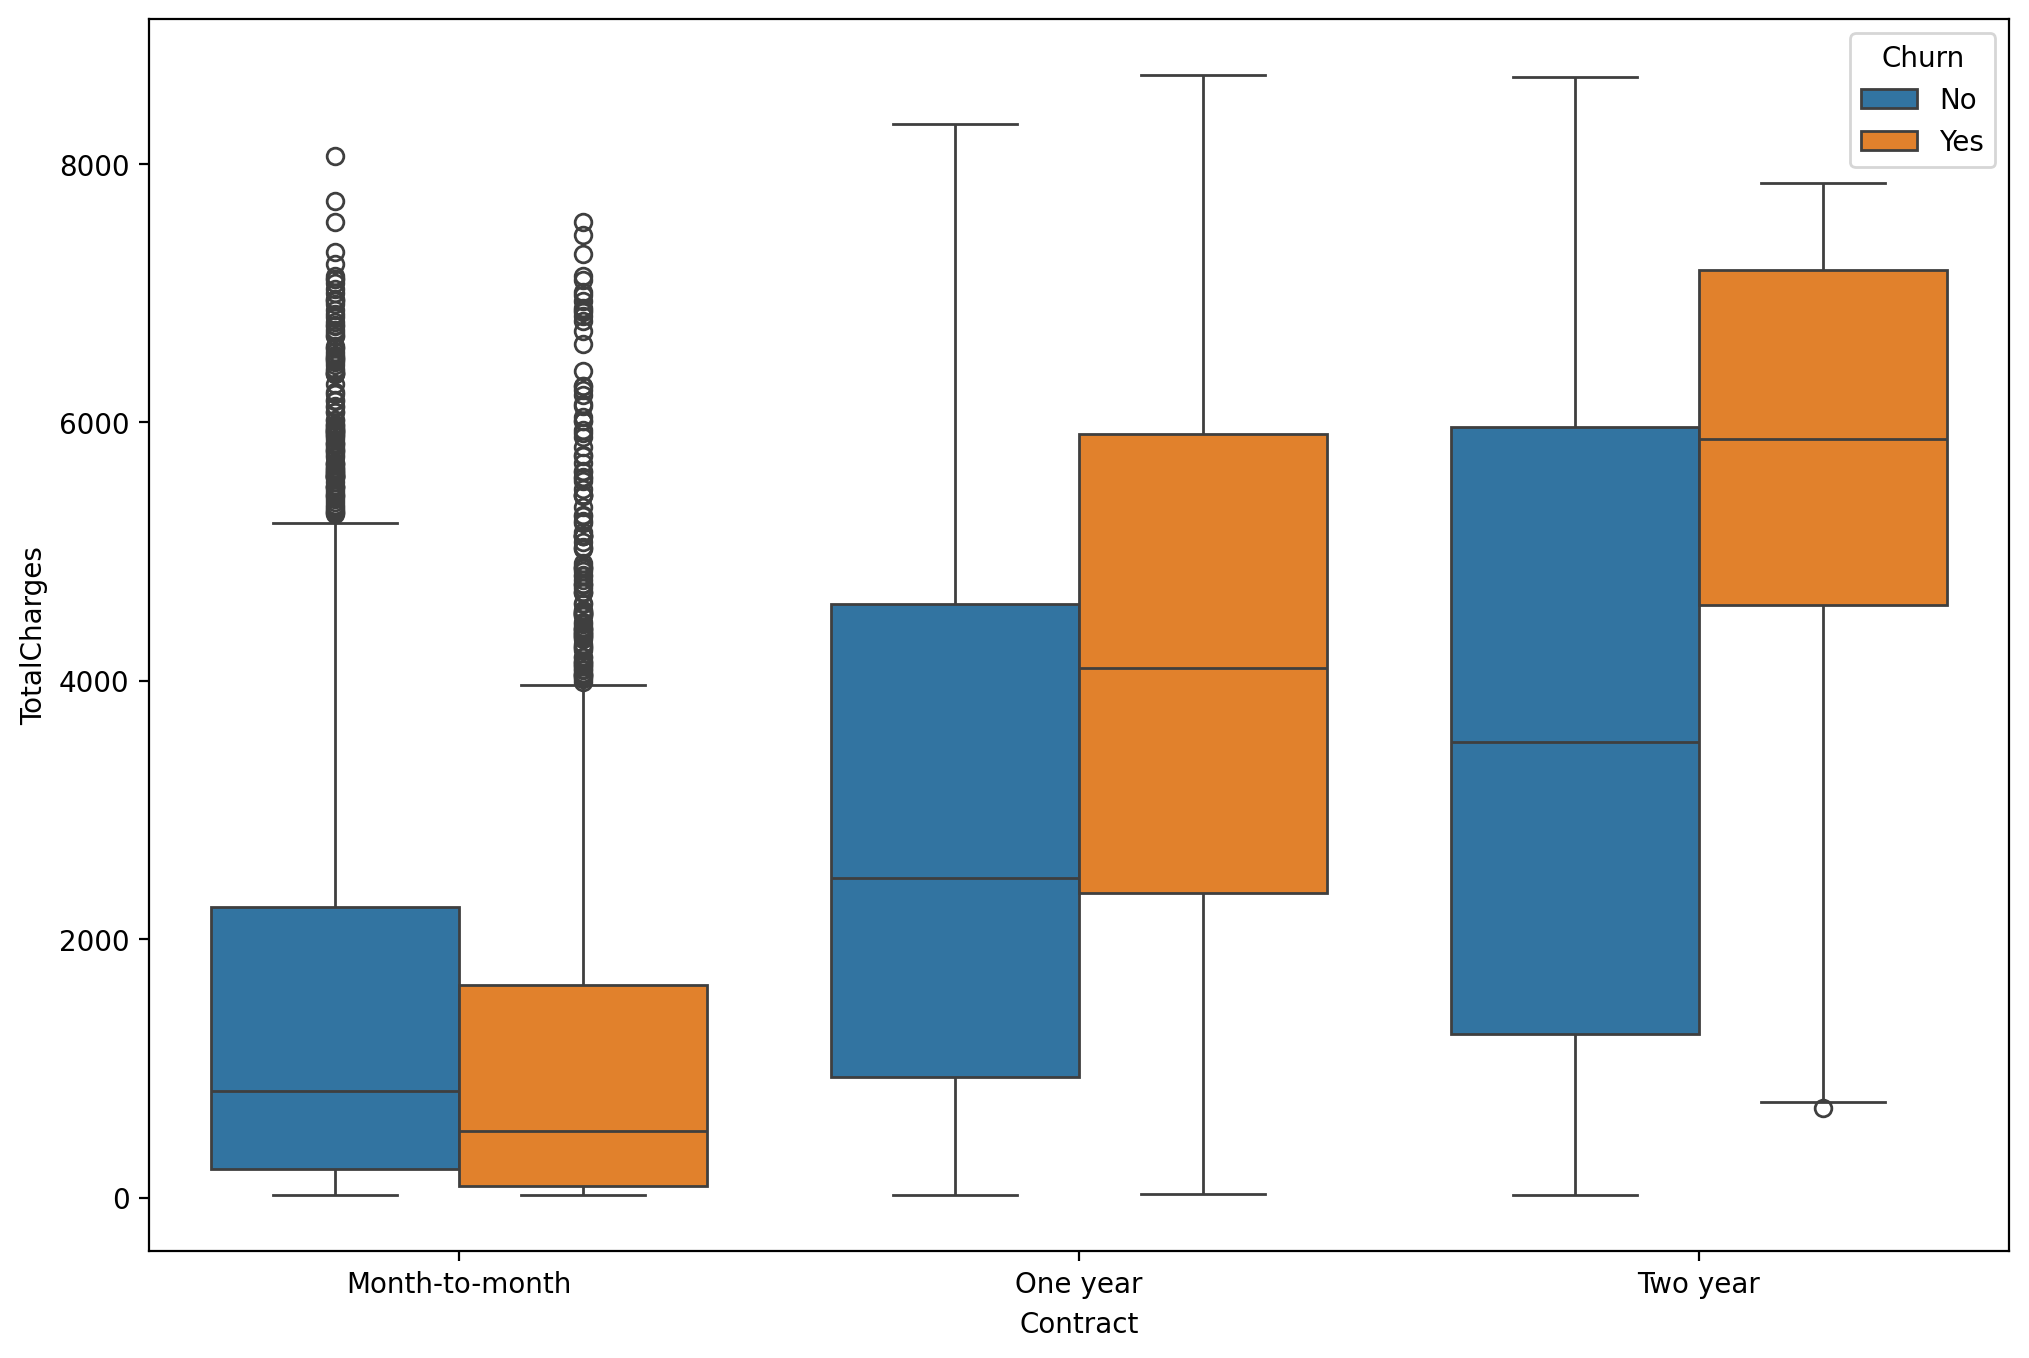

In [18]:
plt.figure(figsize=(12, 8), dpi=200)
sns.boxplot(data=df, x='Contract', y='TotalCharges', hue='Churn')
plt.show()

Для контрактов month-to-month, количество Churn='Yes' и Churn='No' примерно одинаковое, для годовых котрактов - ситуация схожа. Для двухлетних контрактов - количество людей уходящих в отток уже меньше.

Для котрактов первого типа - люди скорее всего решили, что будут пользоваться услугами всего месяц, отток в этой категории контрактов может объясняться такой причиной. 

Для годовых контрактов - оранжевый столбец Churn='Yes' по вертикали имеет заметно большие значения, чем синий столбец Churn='No'. Получается, что в отток уходят те, кто платит больше.

Для двухлетних контрактов - картина такая же, в отток ухоят те, у кого большие значения TotalCharges - т.е. люди платят много денег, но либо не получают нужного качества услуг, либо находят более выгодные условия у конкурентов и поэтому уходят в отток.

Необходимо исследовать, почему у отдельных людей TotalCharges выше. Возможно им можно предложить какие-нибудь персональные скидки и предложения.

**Построим график barplot с корреляции указанных ниже признаков с целевой переменной. ВАЖНО: для категориальных признаков сначала нужно сконвертировать их в дамми-переменные, потому что корреляция вычисляется только для числовых колонок.**

    ['gender', 'SeniorCitizen', 'Partner', 'Dependents','PhoneService', 'MultipleLines', 
     'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'InternetService',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

***Здесь специально приведён список признаков, чтобы не проверять все признаки. Дело в том, что некоторые признаки имеют слишком много уникальных значений для такого анализа, например колонка customerID.***

Так как мы будем визуализировать корреляции между отдельными переменными и целевой переменной - дублирование не убираем, чтобы было удобно посмотреть на корреляции, допустим, между *gender_Male* и *Churn_Yes* и между *gender_Female* и *Churn_Yes*. Но для алгоритмов машинного обучения было бы лучше удалить такое дублирование в будущем для того, чтобы избежать мультиколлинеарности признаков.

In [20]:
corr_df = pd.get_dummies(df[['gender', 'SeniorCitizen', 'Partner', 'Dependents','PhoneService', 'MultipleLines', 
 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'InternetService',
   'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']], dtype='int').corr()
corr_df.head()

SeniorCitizen  gender_Female  gender_Male  Partner_No  \
SeniorCitizen       1.000000       0.001819    -0.001819   -0.016957   
gender_Female       0.001819       1.000000    -1.000000   -0.001379   
gender_Male        -0.001819      -1.000000     1.000000    0.001379   
Partner_No         -0.016957      -0.001379     0.001379    1.000000   
Partner_Yes         0.016957       0.001379    -0.001379   -1.000000   

               Partner_Yes  Dependents_No  Dependents_Yes  PhoneService_No  \
SeniorCitizen     0.016957       0.210550       -0.210550        -0.008392   
gender_Female     0.001379       0.010349       -0.010349        -0.007515   
gender_Male      -0.001379      -0.010349        0.010349         0.007515   
Partner_No       -1.000000       0.452269       -0.452269         0.018397   
Partner_Yes       1.000000      -0.452269        0.452269        -0.018397   

               PhoneService_Yes  MultipleLines_No  ...  Contract_One year  \
SeniorCitizen          0.008392         -0.136377  ...          -0.046491   
gender_Female          0.007515         -0.004335  ...          -0.007755   
gender_Male           -0.007515          0.004335  ...           0.007755   
Partner_No            -0.018397          0.130028  ...          -0.083067   
Partner_Yes            0.018397         -0.130028  ...           0.083067   

               Contract_Two year  PaperlessBilling_No  PaperlessBilling_Yes  \
SeniorCitizen          -0.116205            -0.156258              0.156258   
gender_Female           0.003603            -0.011902              0.011902   
gender_Male            -0.003603             0.011902             -0.011902   
Partner_No             -0.247334            -0.013957              0.013957   
Partner_Yes             0.247334             0.013957             -0.013957   

               PaymentMethod_Bank transfer (automatic)  \
SeniorCitizen                                -0.016235   
gender_Female                                 0.015973   
gender_Male                                  -0.015973   
Partner_No                                   -0.111406   
Partner_Yes                                   0.111406   

               PaymentMethod_Credit card (automatic)  \
SeniorCitizen                              -0.024359   
gender_Female                              -0.001632   
gender_Male                                 0.001632   
Partner_No                                 -0.082327   
Partner_Yes                                 0.082327   

               PaymentMethod_Electronic check  PaymentMethod_Mailed check  \
SeniorCitizen                        0.171322                   -0.152987   
gender_Female                       -0.000844                   -0.013199   
gender_Male                          0.000844                    0.013199   
Partner_No                           0.083207                    0.096948   
Partner_Yes                         -0.083207                   -0.096948   

               Churn_No  Churn_Yes  
SeniorCitizen -0.150541   0.150541  
gender_Female -0.008545   0.008545  
gender_Male    0.008545  -0.008545  
Partner_No    -0.149982   0.149982  
Partner_Yes    0.149982  -0.149982  

[5 rows x 44 columns]

In [22]:
corr_df['Churn_Yes'].sort_values().iloc[1:-1]

Contract_Two year                         -0.301552
OnlineSecurity_No internet service        -0.227578
TechSupport_No internet service           -0.227578
InternetService_No                        -0.227578
OnlineBackup_No internet service          -0.227578
StreamingMovies_No internet service       -0.227578
StreamingTV_No internet service           -0.227578
DeviceProtection_No internet service      -0.227578
PaperlessBilling_No                       -0.191454
Contract_One year                         -0.178225
OnlineSecurity_Yes                        -0.171270
TechSupport_Yes                           -0.164716
Dependents_Yes                            -0.163128
Partner_Yes                               -0.149982
PaymentMethod_Credit card (automatic)     -0.134687
InternetService_DSL                       -0.124141
PaymentMethod_Bank transfer (automatic)   -0.118136
PaymentMethod_Mailed check                -0.090773
OnlineBackup_Yes                          -0.082307
DeviceProtec

In [24]:
corr_yes_churn = corr_df['Churn_Yes'].sort_values().iloc[1:-1]

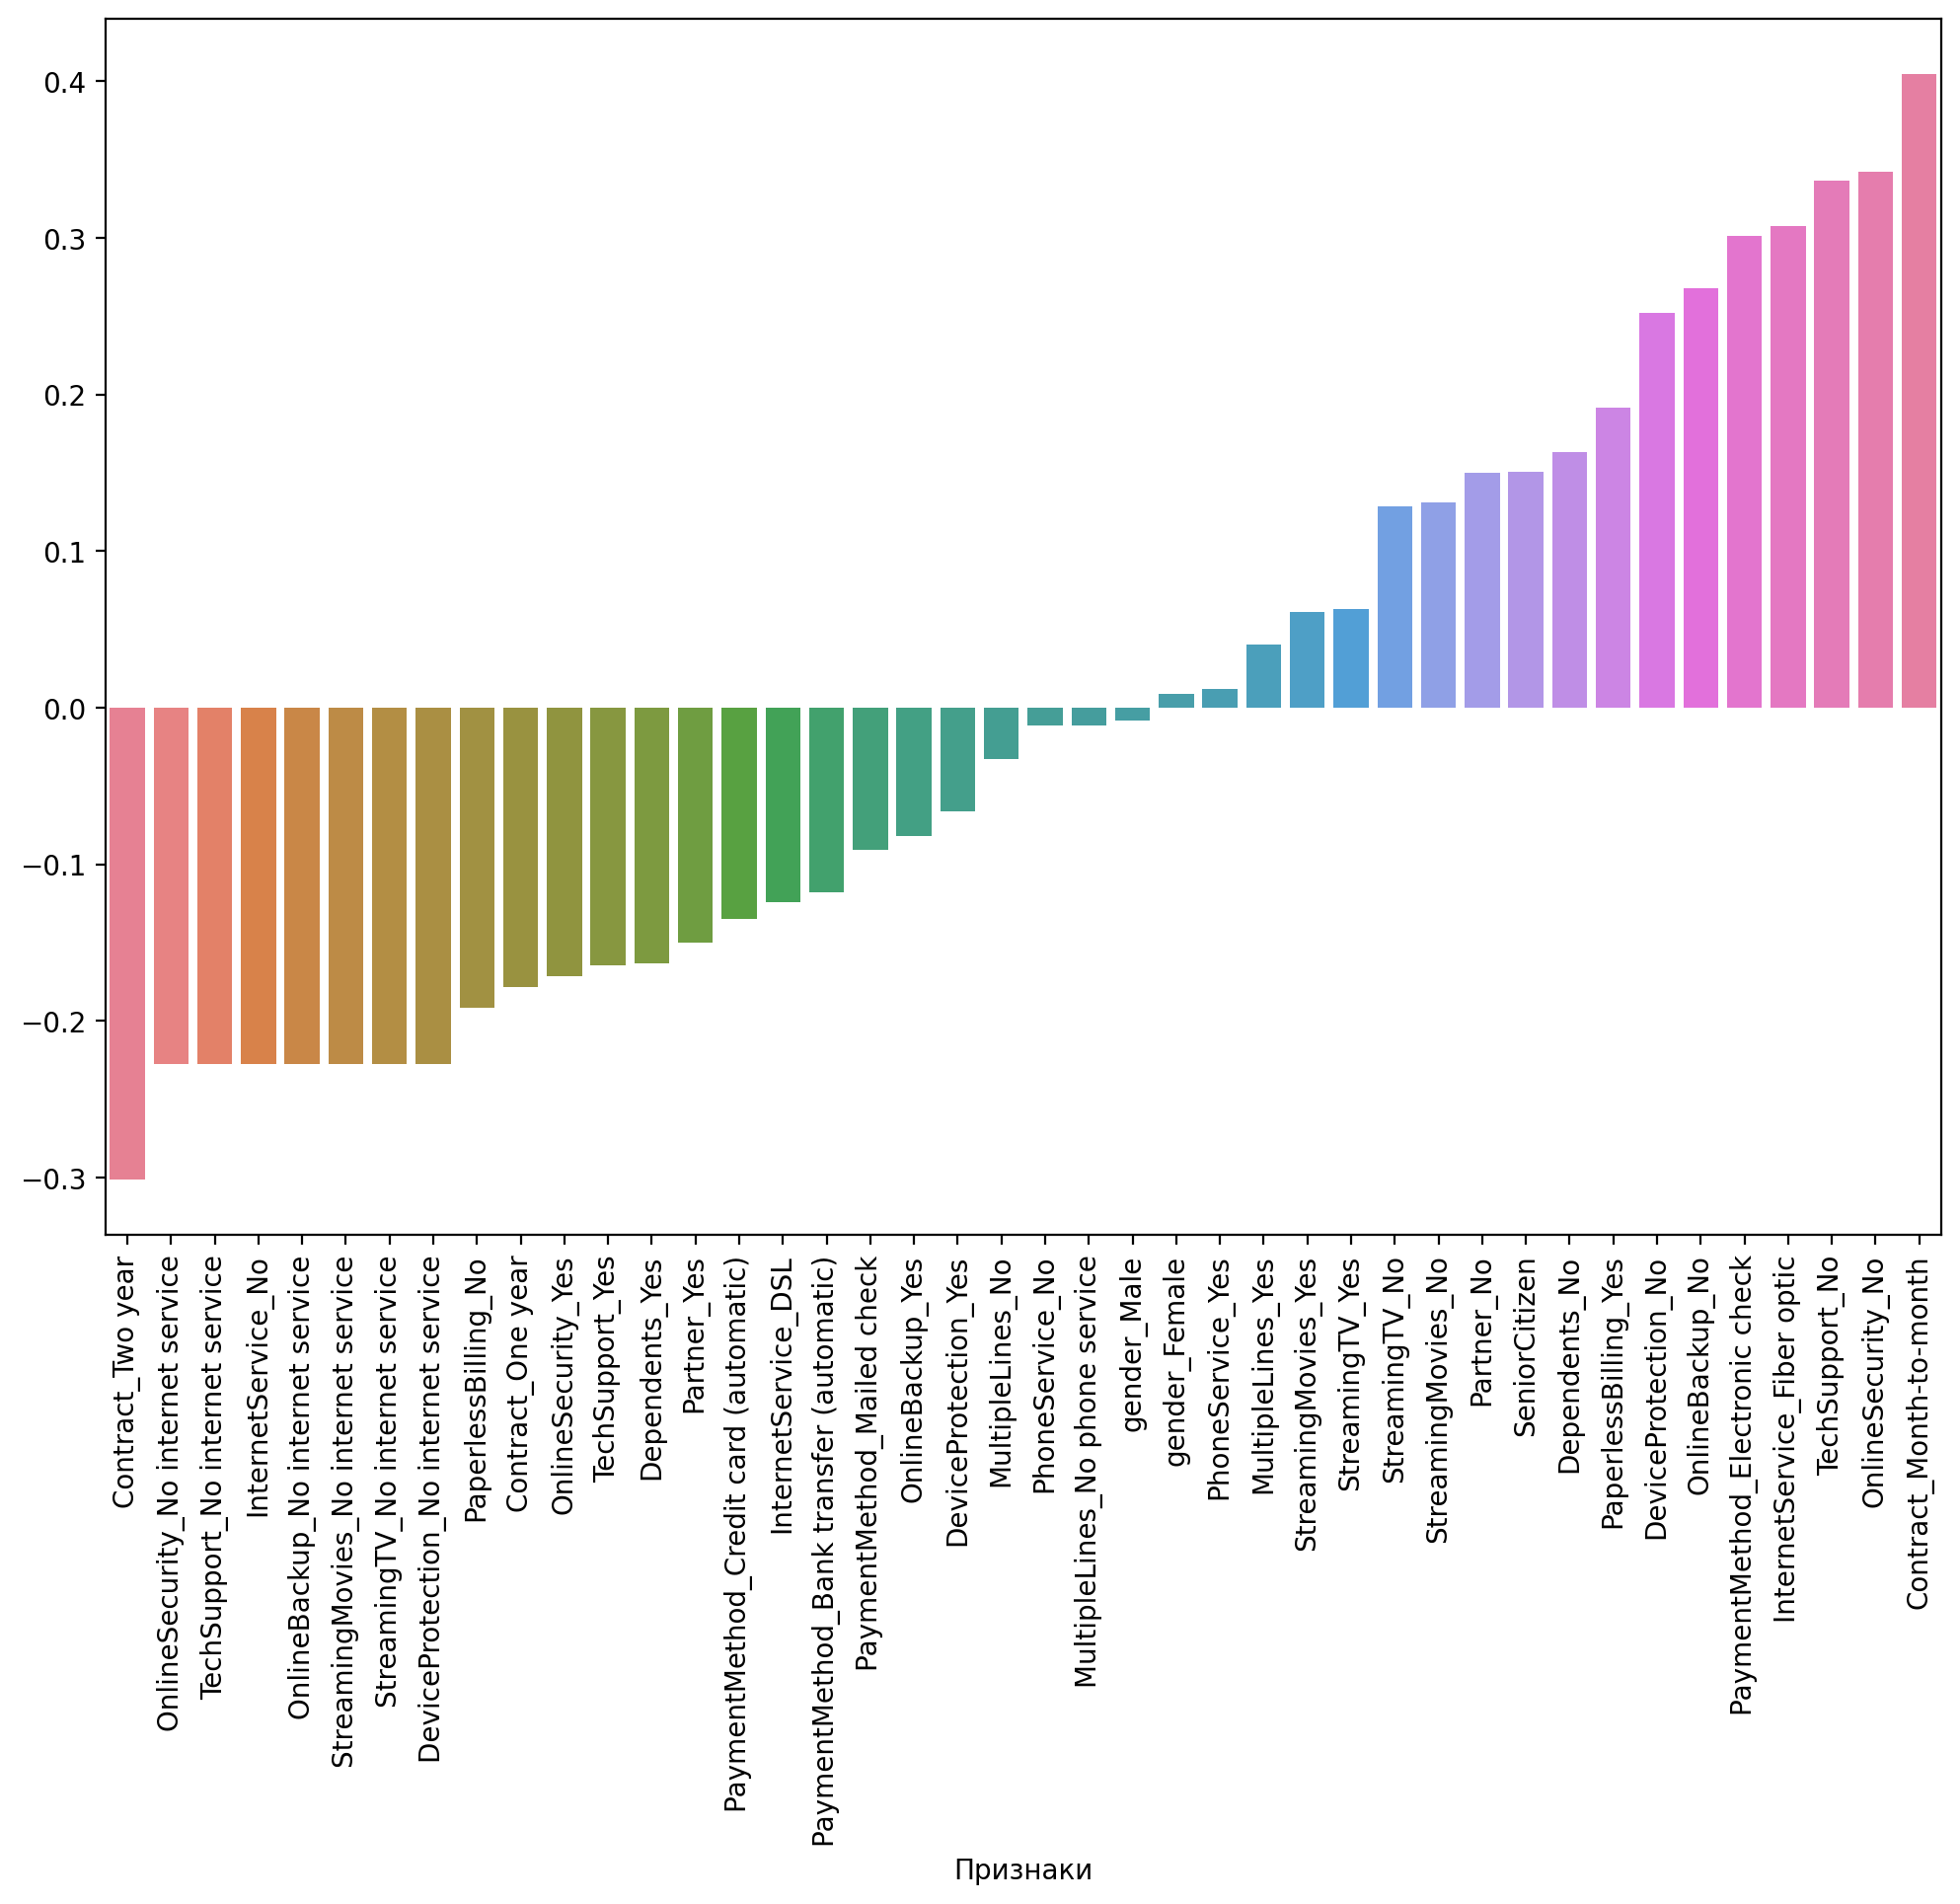

In [26]:
plt.figure(figsize=(12, 8), dpi=200)
sns.barplot(x=corr_yes_churn.index, y=corr_yes_churn.values, hue=corr_yes_churn.index)
plt.xticks(rotation=90)
plt.xlabel('Признаки')
plt.show()

---
---

# Часть 3: Анализ оттока

**В этой части мы выполним сегментацию абонентов на основе колонки tenure, создавая "когорты" и выполняя сравнение данных между различными когортами.**

**Перечислим 3 типа контракта (колонка Contract).**

In [28]:
df['Contract'].unique()

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

**Создадим гистограмму с распределением значений колонки tenure - это количество месяцев, сколько времени человек является (или являлся) абонентом компании.**

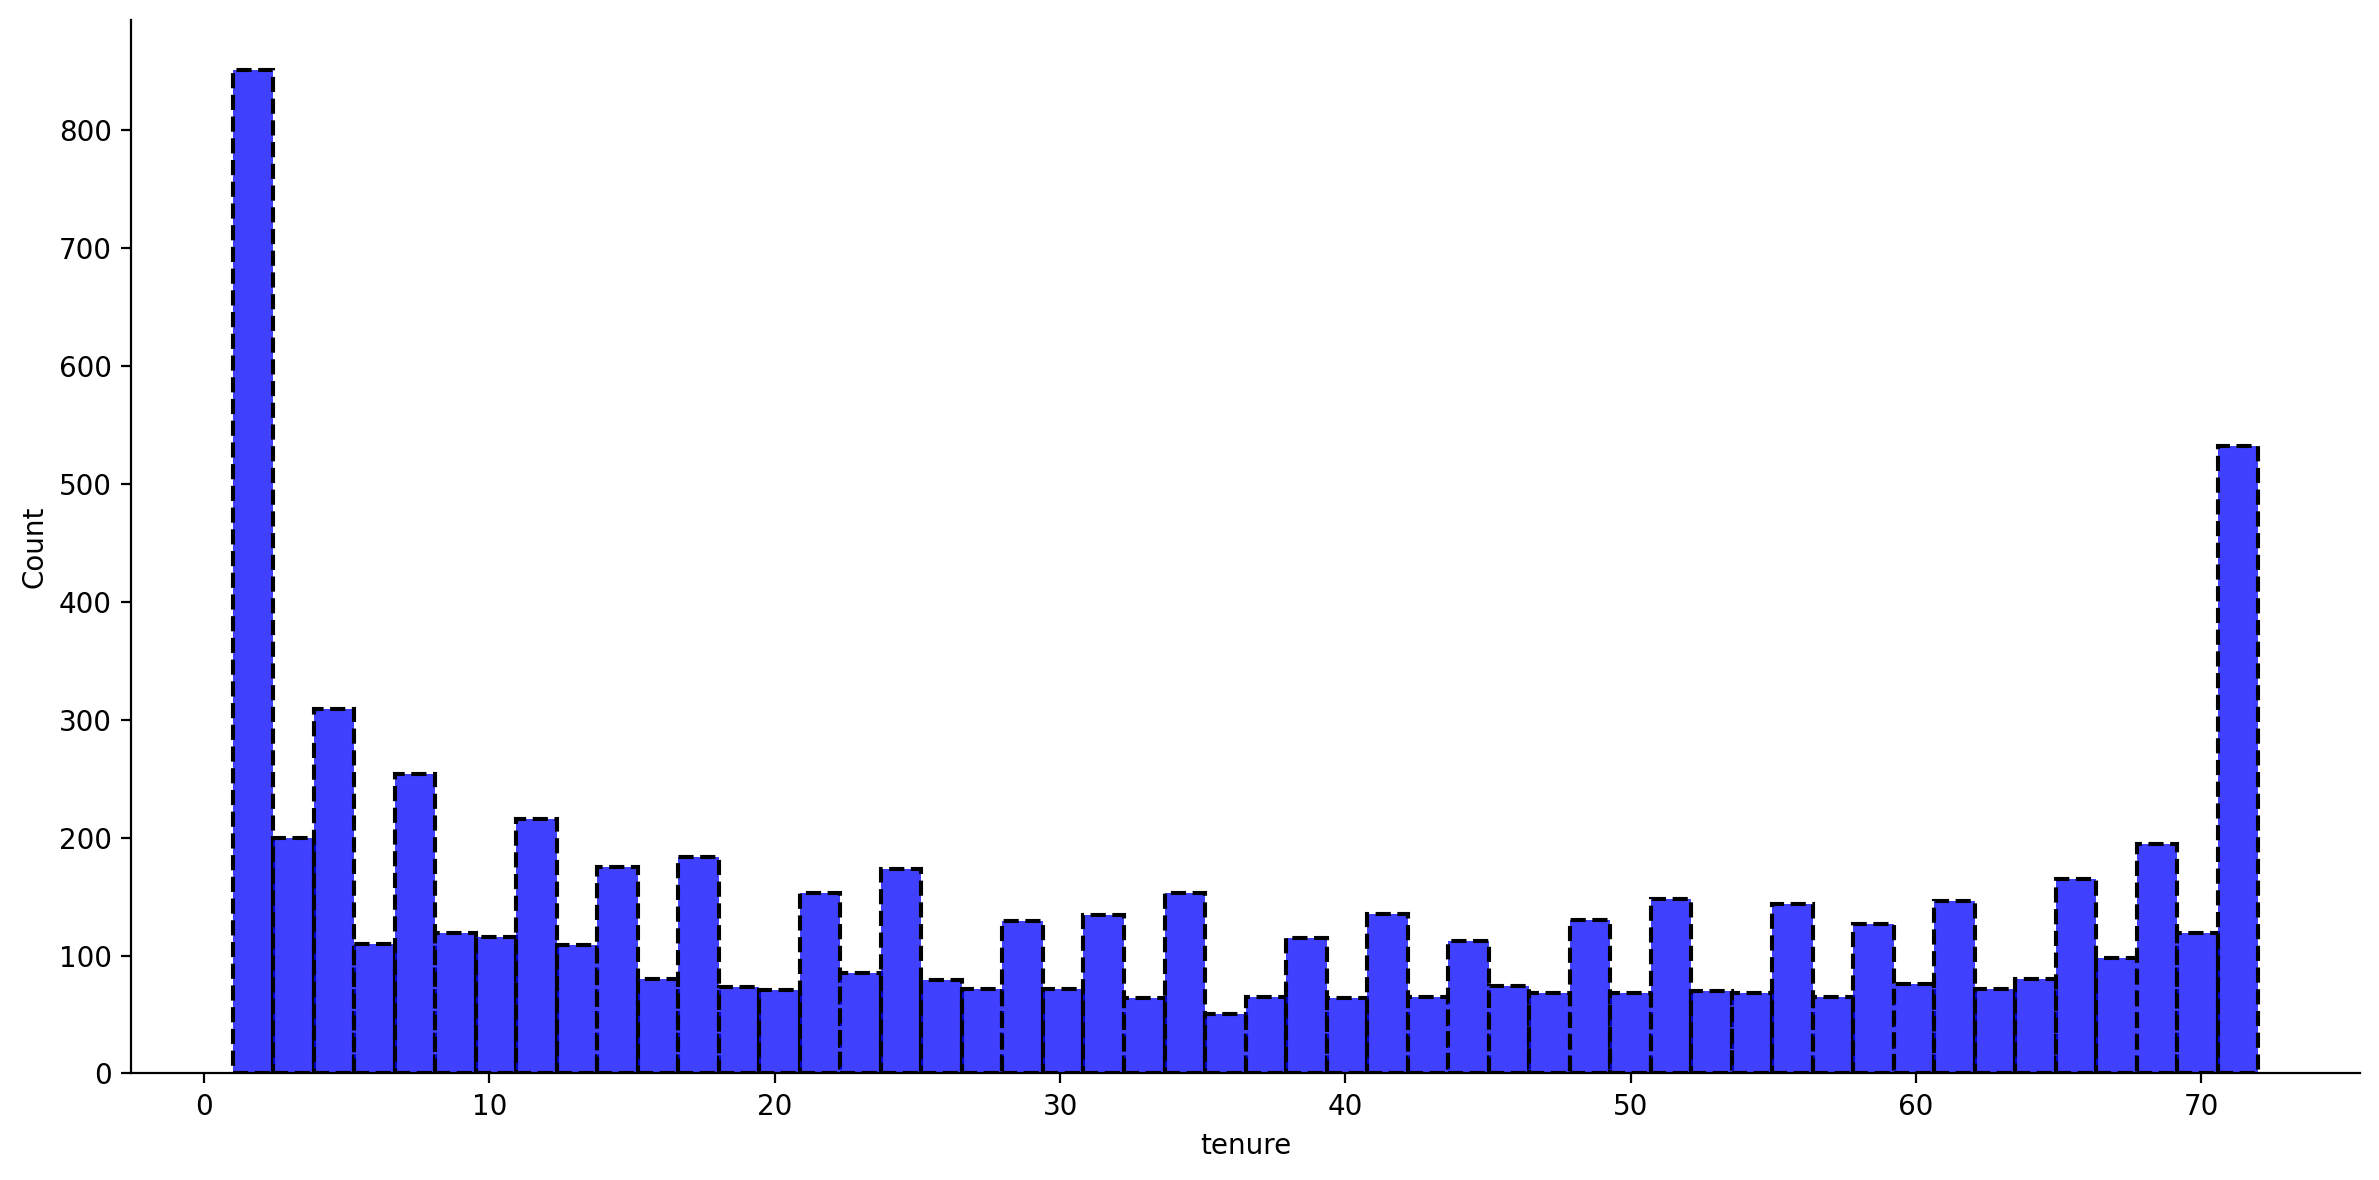

In [30]:
sns.displot(data=df, x='tenure', color='blue', edgecolor='black', lw=4, ls='--', bins=50, height=6, aspect=2).fig.set_dpi(200)
plt.show()

**Построим гистограммы для колонки tenure, разбивая данные по двум колонкам - Churn и Contract.**

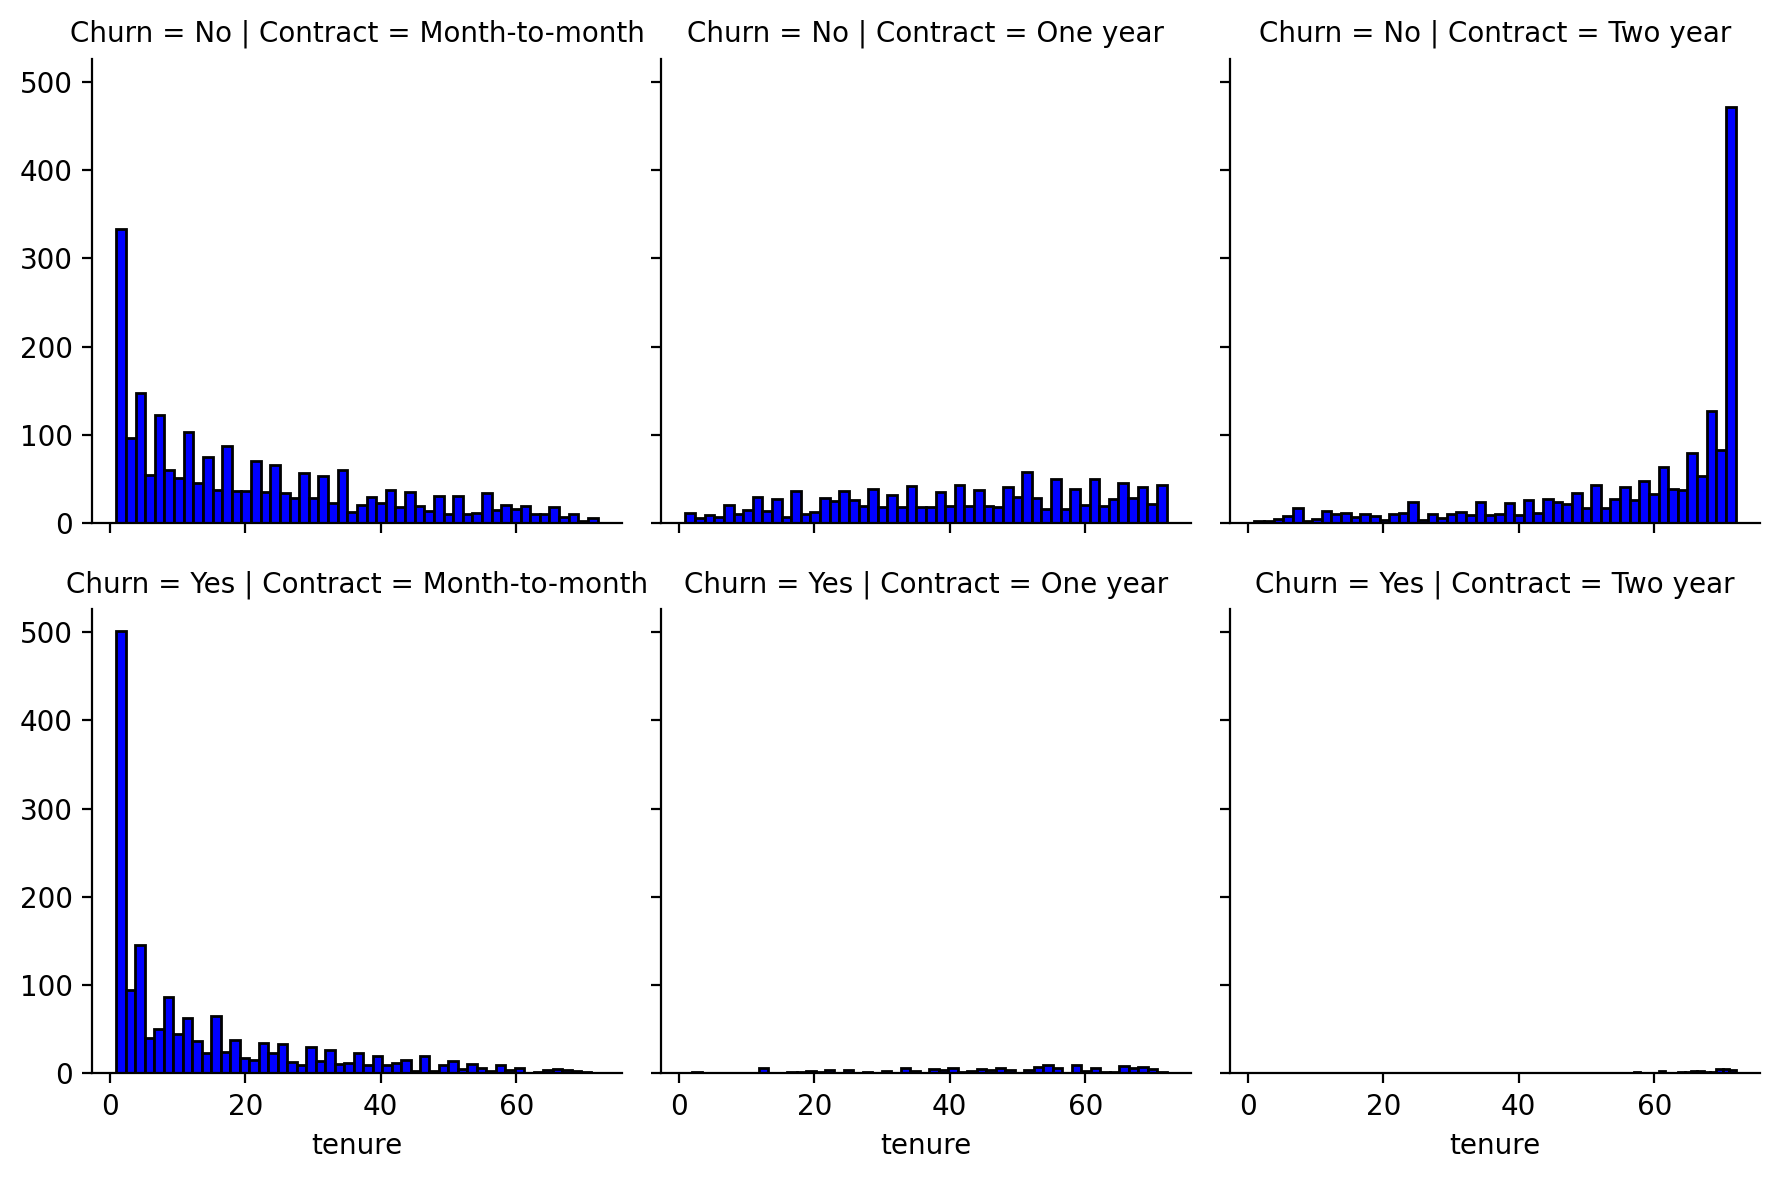

In [32]:
g = sns.FacetGrid(data=df, row='Churn', col='Contract')
g = g.map(plt.hist, 'tenure', color='blue', edgecolor='black', lw=4, ls='--', bins=50).fig.set_dpi(200)
plt.show()

In [ ]:
# Можно так
sns.displot(data=df, x='tenure', bins=70, col='Contract', row='Churn')

По графикам для контрактов в один и два года - уходящих в отток пользователей мало, поэтому следует более внимательно рассмотреть ежемесячные контракты. 

Для таких контрактов наблюдается пик в районе от одного до двух месяцев, но затем - пологое распределение. Так как это распределение по колонке tenure, то мы видим людей, которые находятся на таких контрактах 20, 30 и более месяцев - выглядит странным, что они не переходят на долгосрочные контракты. 

Ранее было видно, что люди уходят в отток, при высоких значениях расходов TotalCharges, но на ежемесячных контрактах могут быть более высокие цены, чем на контрактах в один год или два года. Получается, что таким абанентам также можно предложить какие-нибудь выгодные условия с целью их перехода на долгосрочные контракты.

**Построим график scatterplot для колонок Total Charges и Monthly Charges, раскрашивая график цветами по колонке Churn.**

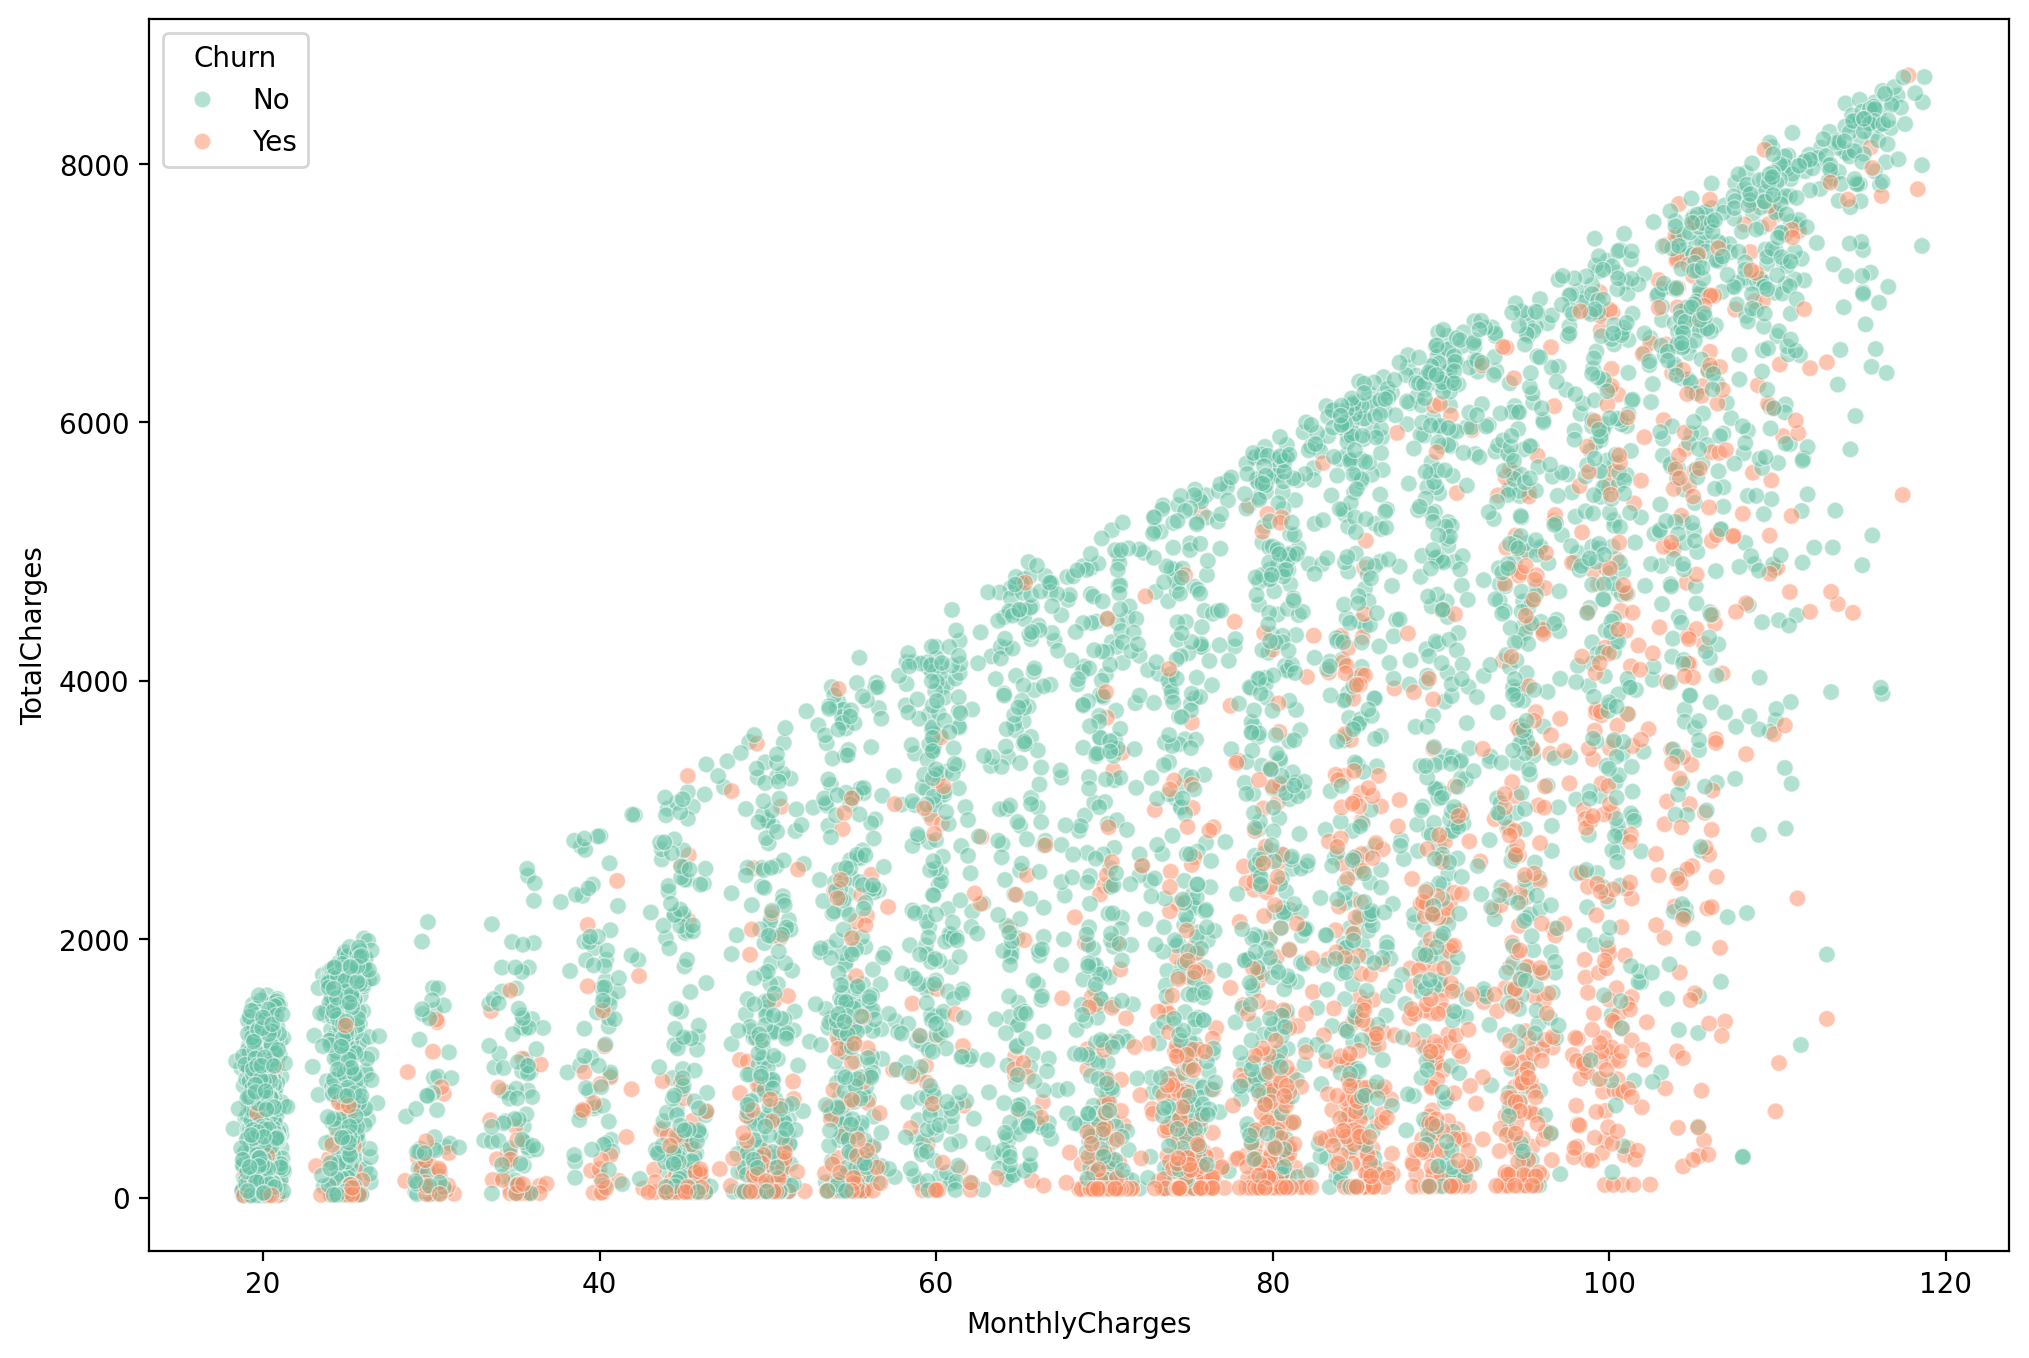

In [34]:
plt.figure(figsize=(12, 8), dpi=200)
sns.scatterplot(data=df, x='MonthlyCharges', y='TotalCharges', hue='Churn', palette='Set2', alpha=0.5)
plt.show()

### Создание когорт (сегментов) по колонке Tenure

**Для начала поместим различные значения tenure (1 месяц, 2 месяца, 3 месяца и так далее) в отдельные когорты (сегменты).**

**Для каждого уникального значения колонки tenure в качестве когорты, вычислим процент оттока (churn rate) - это количество тех людей, кто ушёл в отток в когорте, как процент от общего количества людей в данной когорте. Вычислим такой процент отдельно для каждой когорты. В итоге, должны получиться когорты от 1 до 72 месяцев, и с увеличением количества месяцев уровень оттока должен снижаться. Это разумно, потому что чем дольше человек пользуется услугами компании, тем вероятнее то, что его/её всё устраивает, и он/она продолжит пользоваться этими услугами.**

In [36]:
df['tenure'].unique()

array([ 1, 34,  2, 45,  8, 22, 10, 28, 62, 13, 16, 58, 49, 25, 69, 52, 71,
       21, 12, 30, 47, 72, 17, 27,  5, 46, 11, 70, 63, 43, 15, 60, 18, 66,
        9,  3, 31, 50, 64, 56,  7, 42, 35, 48, 29, 65, 38, 68, 32, 55, 37,
       36, 41,  6,  4, 33, 67, 23, 57, 61, 14, 20, 53, 40, 59, 24, 44, 19,
       54, 51, 26, 39])

In [38]:
churn_rate = []

for t in range(1, 73):
    c_r = len(df[(df['tenure'] == t) & (df['Churn']=='Yes')]) * 100 / len(df[df['tenure'] == t])
    churn_rate.append(c_r)

In [40]:
churn_rate = pd.Series(data=churn_rate, index=range(1, 73))
churn_rate

1     61.990212
2     51.680672
3     47.000000
4     47.159091
5     48.120301
        ...    
68     9.000000
69     8.421053
70     9.243697
71     3.529412
72     1.657459
Length: 72, dtype: float64

In [ ]:
# Можно еще так
yes_churn = df.groupby(['Churn', 'tenure']).count().transpose()['Yes']
no_churn = df.groupby(['Churn', 'tenure']).count().transpose()['No']

In [ ]:
churn_rate = 100 * yes_churn / (no_churn + yes_churn)

In [ ]:
# Получаем проценты, по которым дальше строится график
churn_rate.traspose()['customerID']

**Используя результаты предыдущего шага, построим график процента оттока для различных значений tenure.**

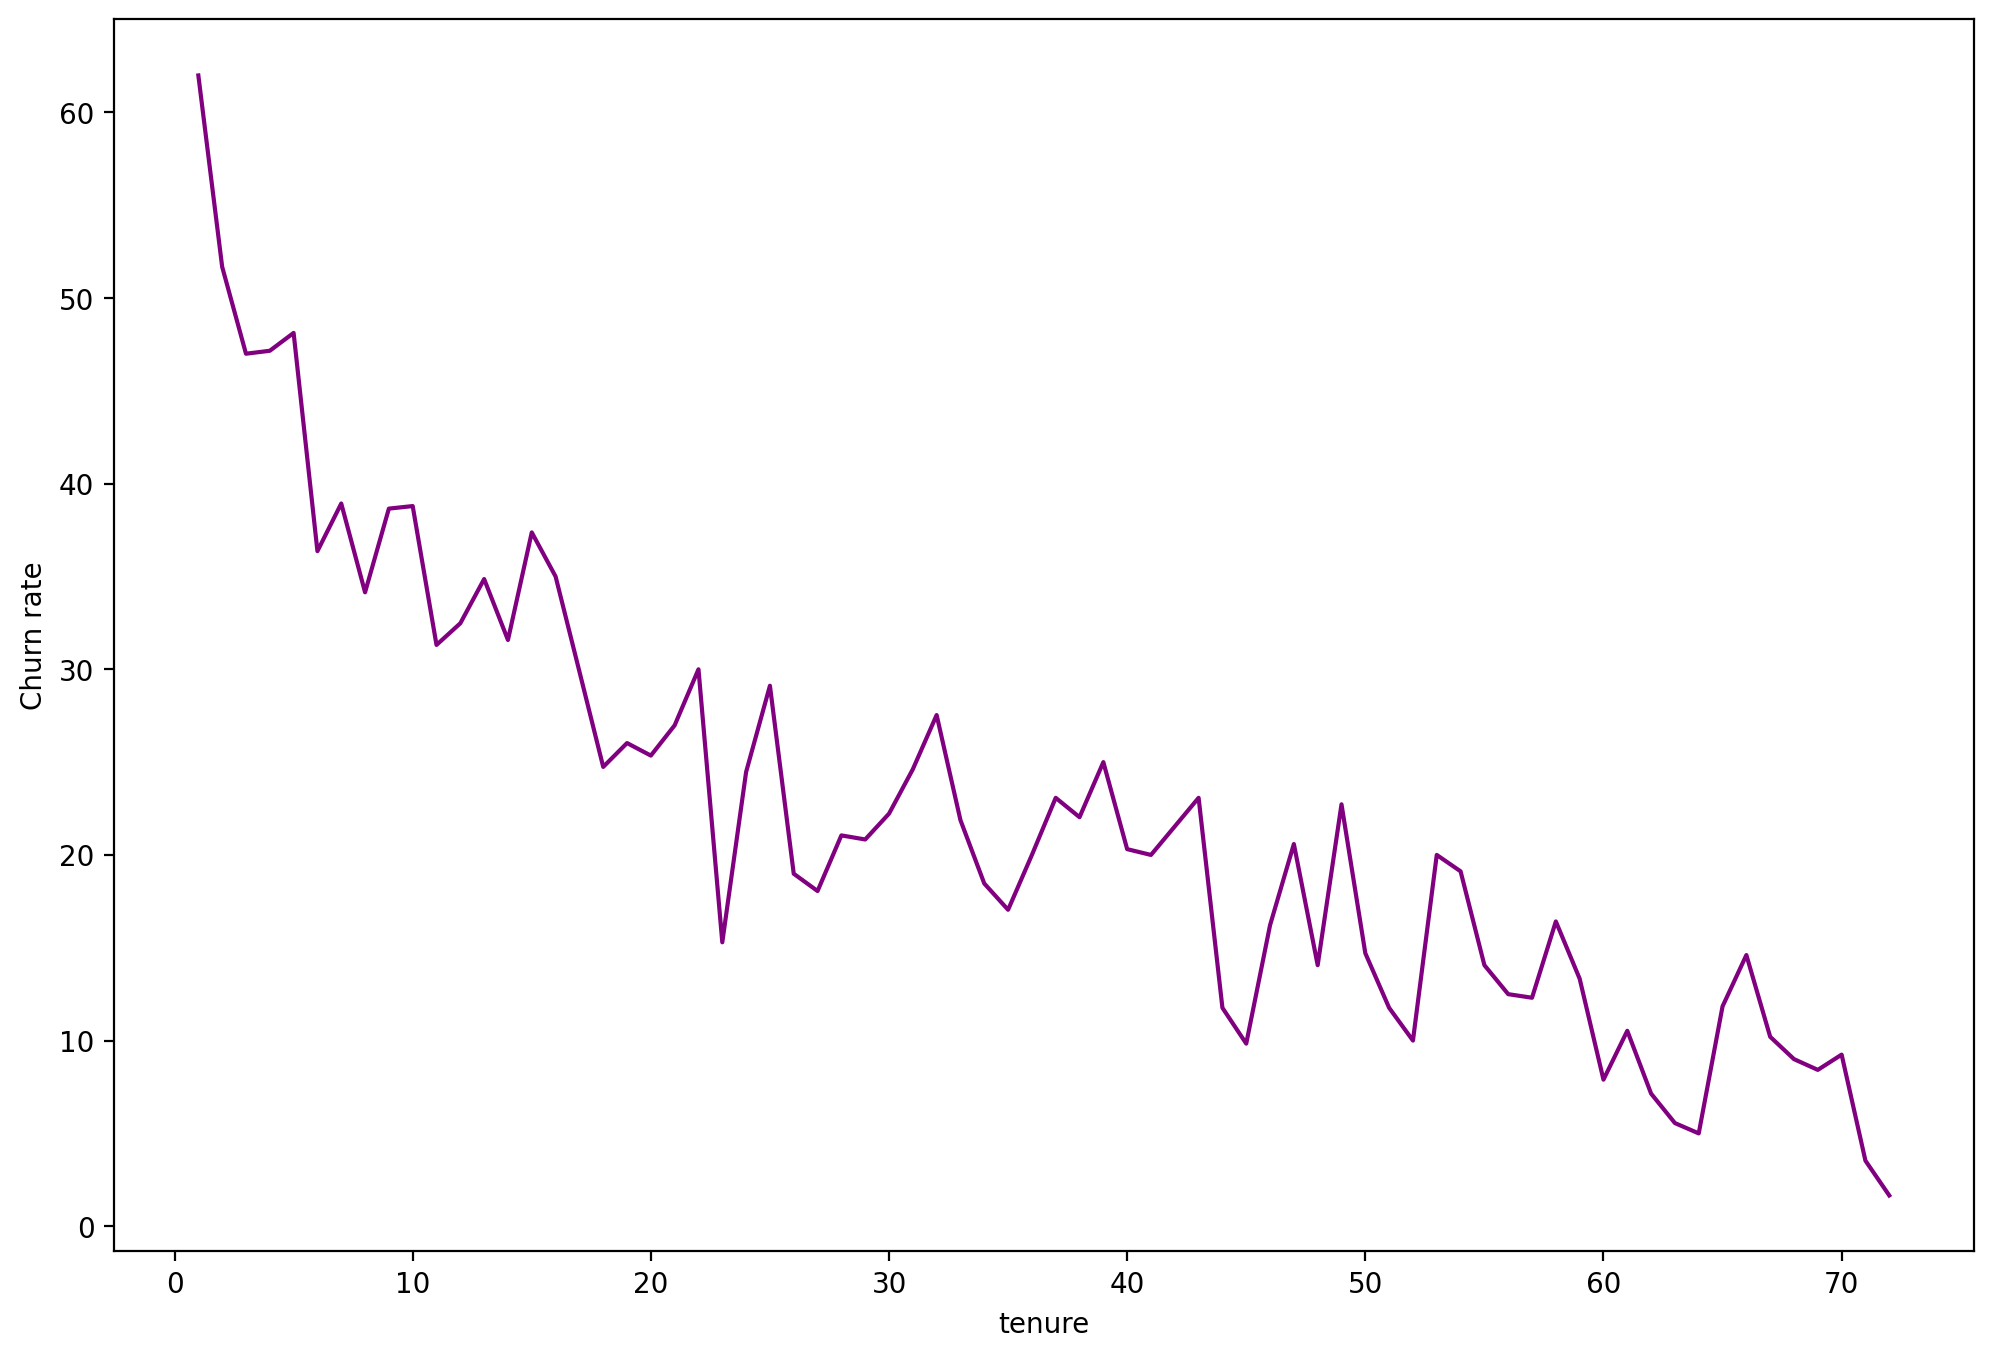

In [42]:
plt.figure(figsize=(12, 8), dpi=200)
plt.plot(churn_rate, color='purple')
plt.xlabel('tenure')
plt.ylabel('Churn rate')
plt.show()

### Более крупные когорты (сегменты)
**На основе колонки tenure создадим новую колонку с названием "Tenure Cohort", в которой будут следующие 4 категории:**
   * '0-12 месяцев'
   * '24-48 месяцев'
   * '12-24 месяцев'
   * 'Более 48 месяцев'    

In [44]:
def cohort(tenure):
    if tenure <= 12:
       return '0-12 месяцев'
    if 12 < tenure <= 24:
        return '12-24 месяцев'
    if 24 < tenure <= 48:
        return '24-48 месяцев'
    if tenure > 48:
        return 'Более 48 месяцев'

In [46]:
df['Tenure Cohort'] = np.vectorize(cohort)(df['tenure'])
df[['tenure', 'Tenure Cohort']].head(10)

tenure     Tenure Cohort
0       1      0-12 месяцев
1      34     24-48 месяцев
2       2      0-12 месяцев
3      45     24-48 месяцев
4       2      0-12 месяцев
5       8      0-12 месяцев
6      22     12-24 месяцев
7      10      0-12 месяцев
8      28     24-48 месяцев
9      62  Более 48 месяцев

**Построим график scatterplot для Total Charges и Monthly Charges, раскрашивая график разными цветами по колонке "Tenure Cohort", которую создали на предыдущем шаге.**

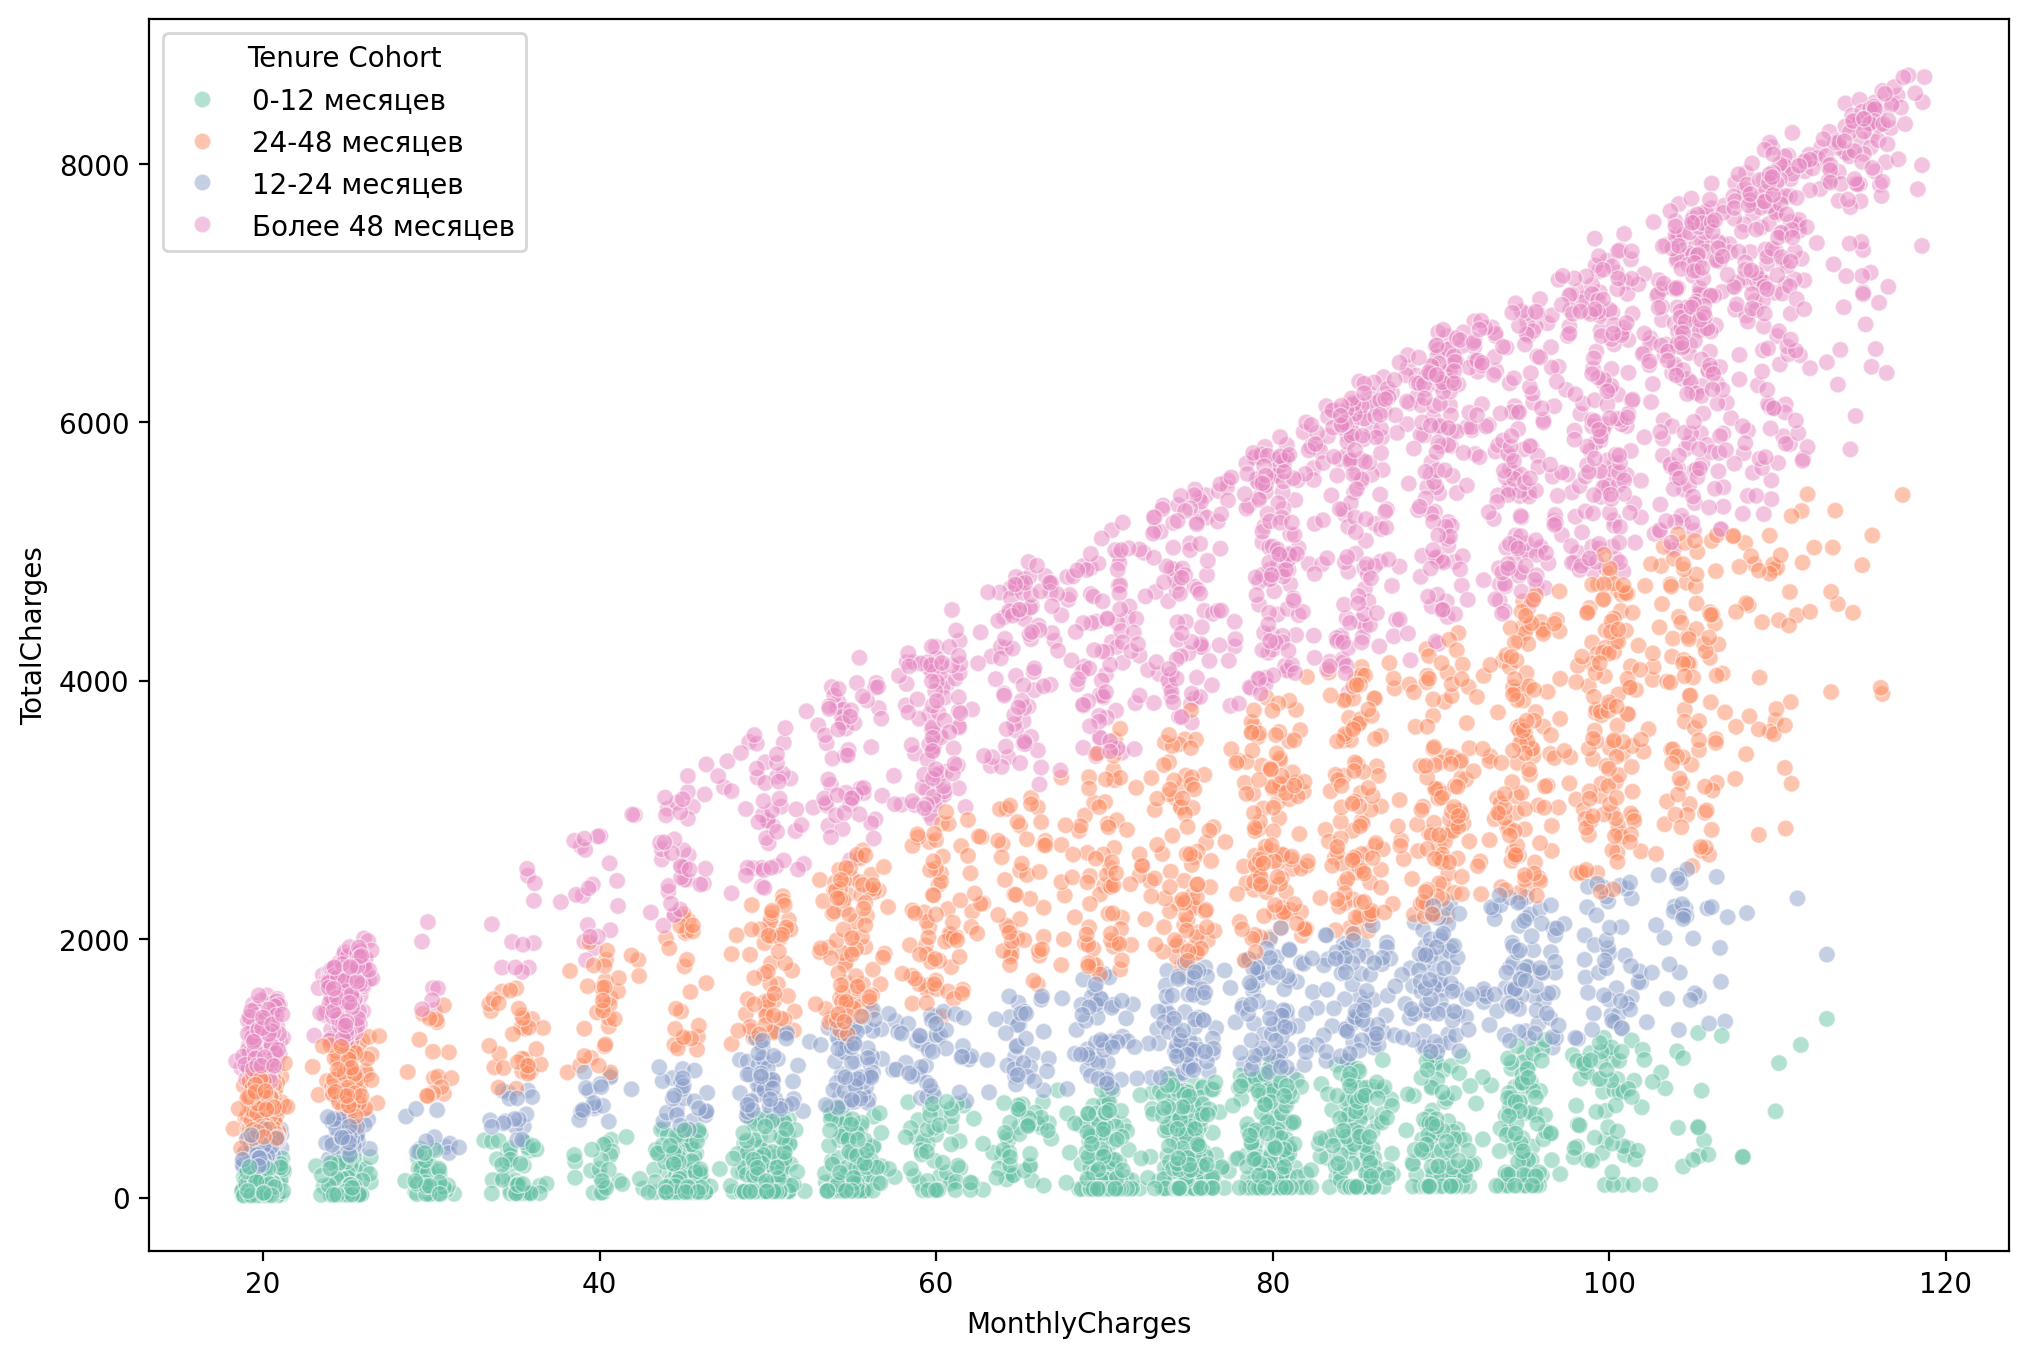

In [48]:
plt.figure(figsize=(12, 8), dpi=200)
sns.scatterplot(data=df, x='MonthlyCharges', y='TotalCharges', hue='Tenure Cohort', palette='Set2', alpha=0.5, linewidth=0.5)
plt.show()

**Построим график countplot с количеством ушедших и не ушедших в отток людей в каждой когорте.**

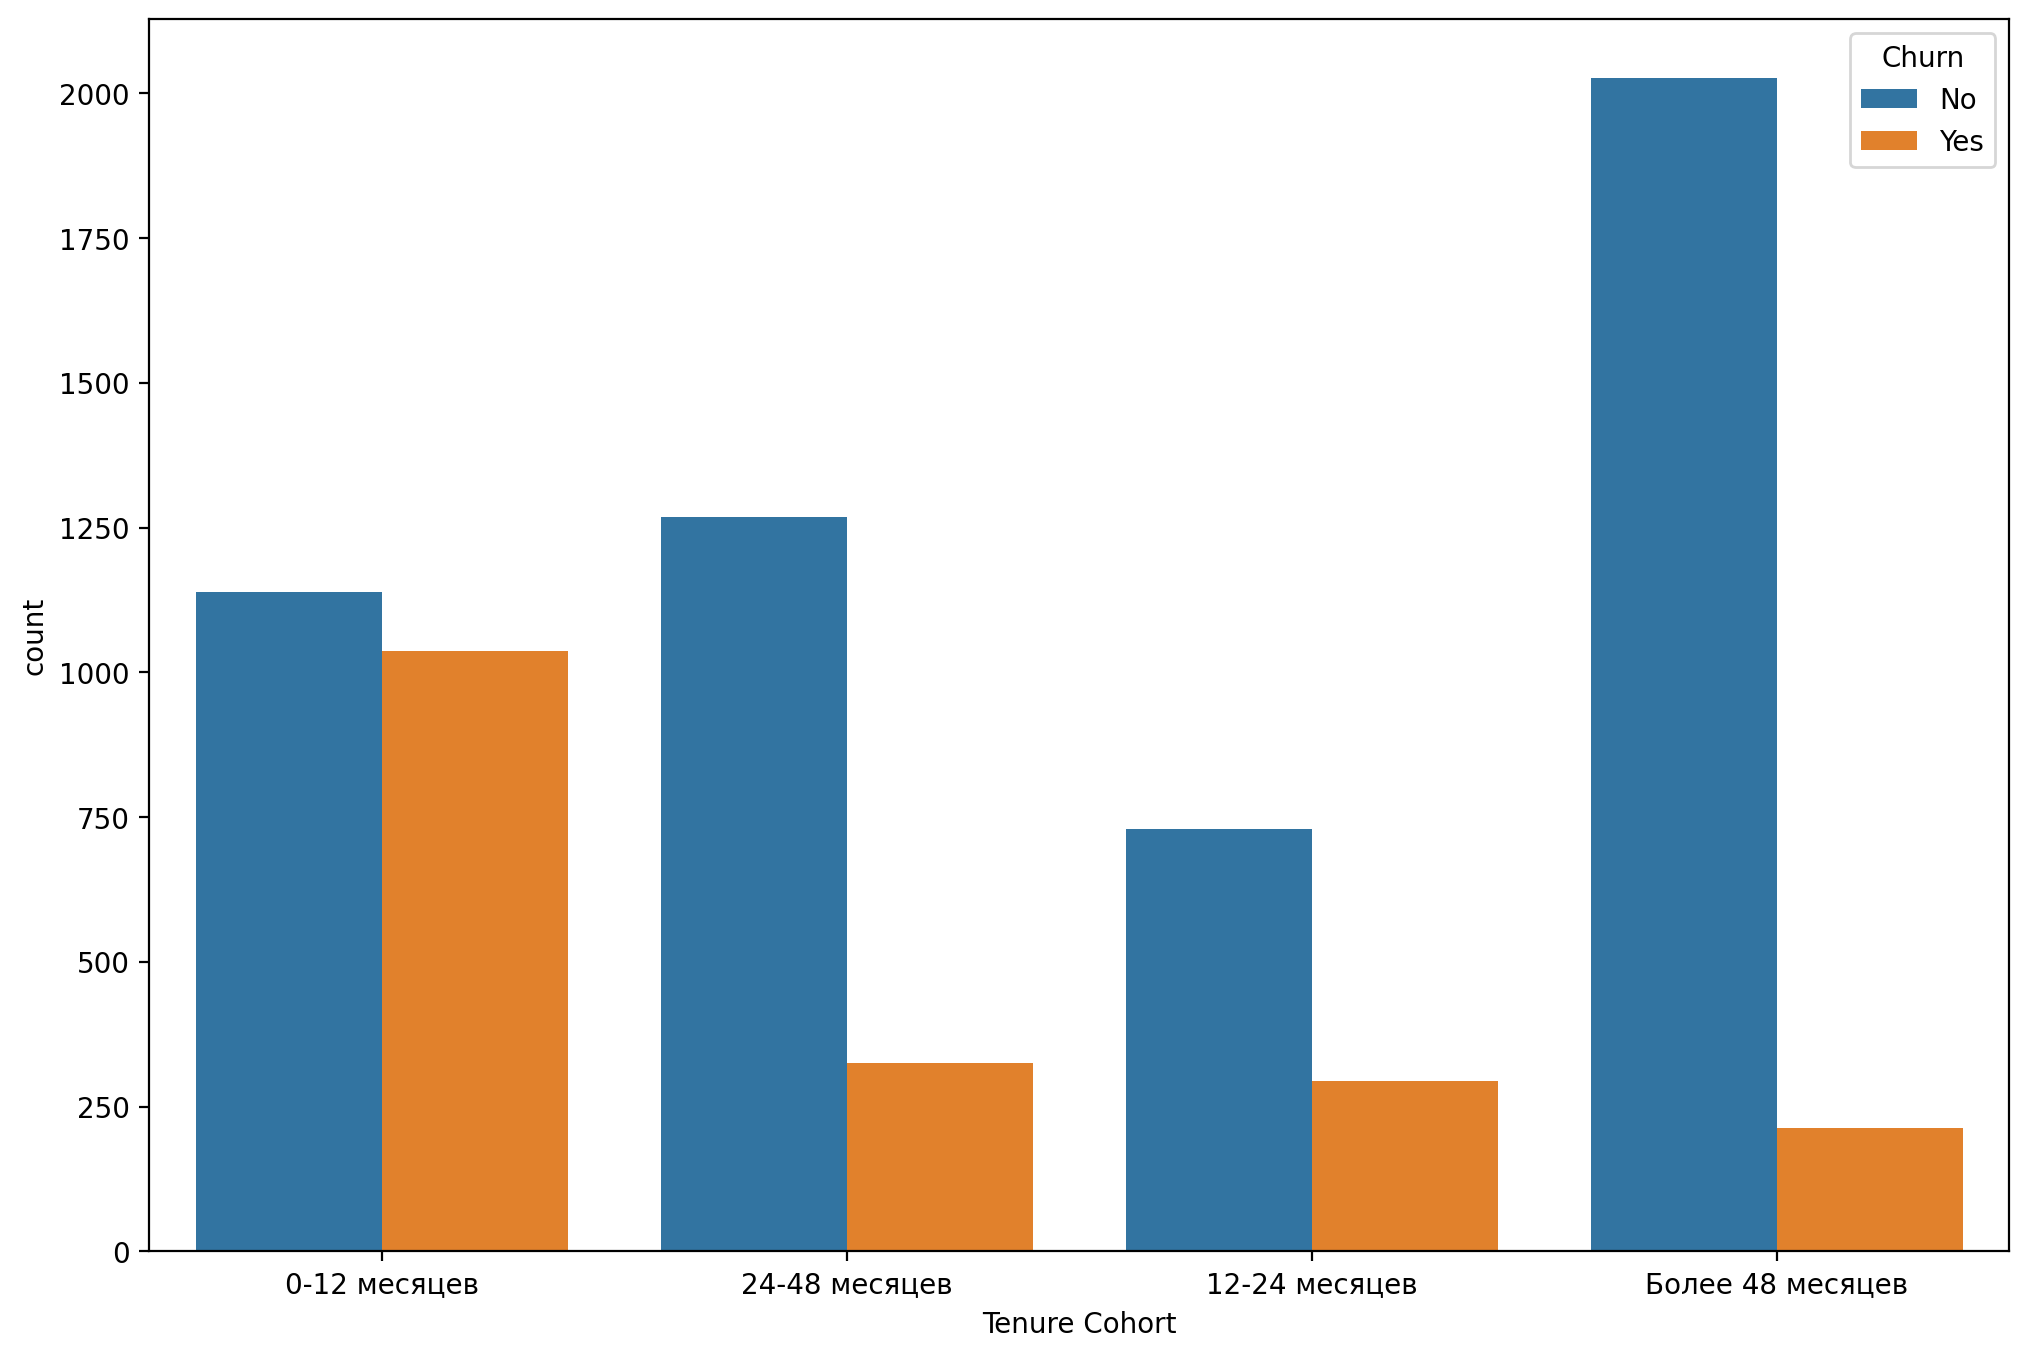

In [50]:
plt.figure(figsize=(12, 8), dpi=200)
sns.countplot(data=df, x='Tenure Cohort', hue='Churn')
plt.show()

**Создадим набор графиков CountPlot с количеством людей по различным когортам Tenure Cohort. Для каждого типа контракта создадим отдельный график, и раскрасим эти графики разными цветами по колонке Churn.**

<Figure size 2400x1600 with 0 Axes>

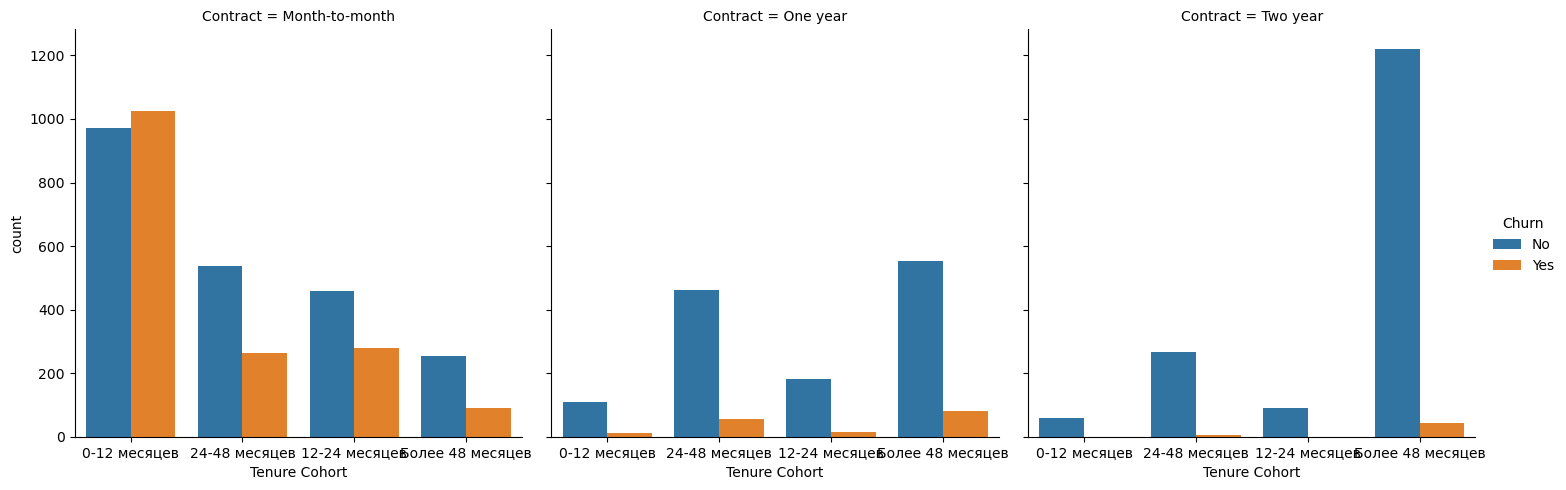

In [52]:
plt.figure(figsize=(12, 8), dpi=200)
sns.catplot(data=df, x='Tenure Cohort', hue='Churn', kind='count', col='Contract', aspect=1)
plt.show()

-----

# Часть 4: Предиктивная модель

**Исследуем 4 модели на основе деревьев: одно дерево решений, случайный лес, адаптивный бустинг и градиентный бустинг.**


## Одно дерево решений (Decision Tree)

**Разделим все данные на признаки X и целевую переменную Y. Создадим дамми-переменные, где это необходимо, а также посмотрим, есть ли какие-то признаки, которые можно было бы удалить.**

In [70]:
dum_df = df.drop(['customerID', 'Tenure Cohort', 'SeniorCitizen', 'Churn'], axis=1)
dum_df = pd.get_dummies(dum_df, drop_first=True, dtype='int')

In [72]:
dum_df[['SeniorCitizen', 'Churn']] = df[['SeniorCitizen', 'Churn']]

In [74]:
dum_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 31 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   tenure                                 7032 non-null   int64  
 1   MonthlyCharges                         7032 non-null   float64
 2   TotalCharges                           7032 non-null   float64
 3   gender_Male                            7032 non-null   int64  
 4   Partner_Yes                            7032 non-null   int64  
 5   Dependents_Yes                         7032 non-null   int64  
 6   PhoneService_Yes                       7032 non-null   int64  
 7   MultipleLines_No phone service         7032 non-null   int64  
 8   MultipleLines_Yes                      7032 non-null   int64  
 9   InternetService_Fiber optic            7032 non-null   int64  
 10  InternetService_No                     7032 non-null   int64  
 11  Onli

In [76]:
X = dum_df.drop('Churn', axis=1)
y = dum_df['Churn']

**Выполним разбиение данных на обучающий и тестовый наборы (train test split), откладывая в сторону 10% данных для тестирования. В решениях будем использовать `random_state=101`.**

In [78]:
from sklearn.model_selection import train_test_split

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=101)

**Построим модель Decision Tree и оценим её работу. Для этого выполним следующие шаги:**
   1. Обучим модель дерева решений.
   2. Оценим метрики работы модели дерева решений - для этого выведем отчёт "classification report" и нарисуем график с матрицей ошибок (confusion matrix).
   3. Посмотрим на важности признаков для получившегося дерева решений.
   4. Опционально: Нарисуем график получившегося дерева. **Важно: если дерево получилось очень большим и не выполнялось усечение дерева с помощью параметров, то вызов метода plot_tree может привести к ошибке.**

In [82]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

In [84]:
tree_model = DecisionTreeClassifier()

In [94]:
param_grid = {'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9],
              'max_leaf_nodes': [2, 3, 4, 5],
              'criterion': ["gini", "entropy", "log_loss"]}

In [96]:
grid = GridSearchCV(tree_model, param_grid)

In [98]:
grid.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'max_leaf_nodes': [2, 3, 4, 5]})

In [100]:
grid.best_estimator_

DecisionTreeClassifier(max_depth=2, max_leaf_nodes=3)

In [102]:
grid.best_params_

{'criterion': 'gini', 'max_depth': 2, 'max_leaf_nodes': 3}

In [106]:
preds = grid.predict(X_test)

In [104]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

In [108]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

          No       0.84      0.94      0.89       557
         Yes       0.60      0.34      0.43       147

    accuracy                           0.81       704
   macro avg       0.72      0.64      0.66       704
weighted avg       0.79      0.81      0.79       704



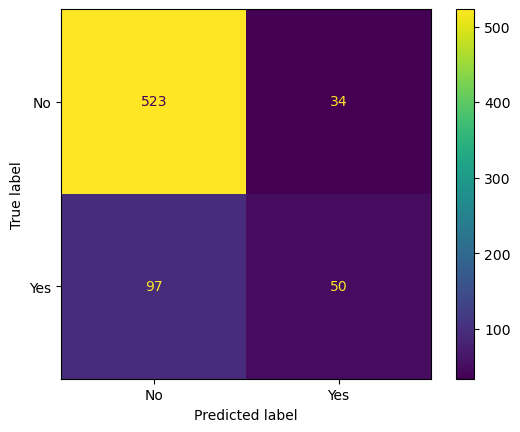

In [110]:
ConfusionMatrixDisplay.from_estimator(grid, X_test, y_test)

In [118]:
feat_import = grid.best_estimator_.feature_importances_

In [120]:
imp_feats = pd.DataFrame(data=feat_import, index=X.columns, columns=['Importance'])

In [124]:
imp_feats = imp_feats.sort_values('Importance')

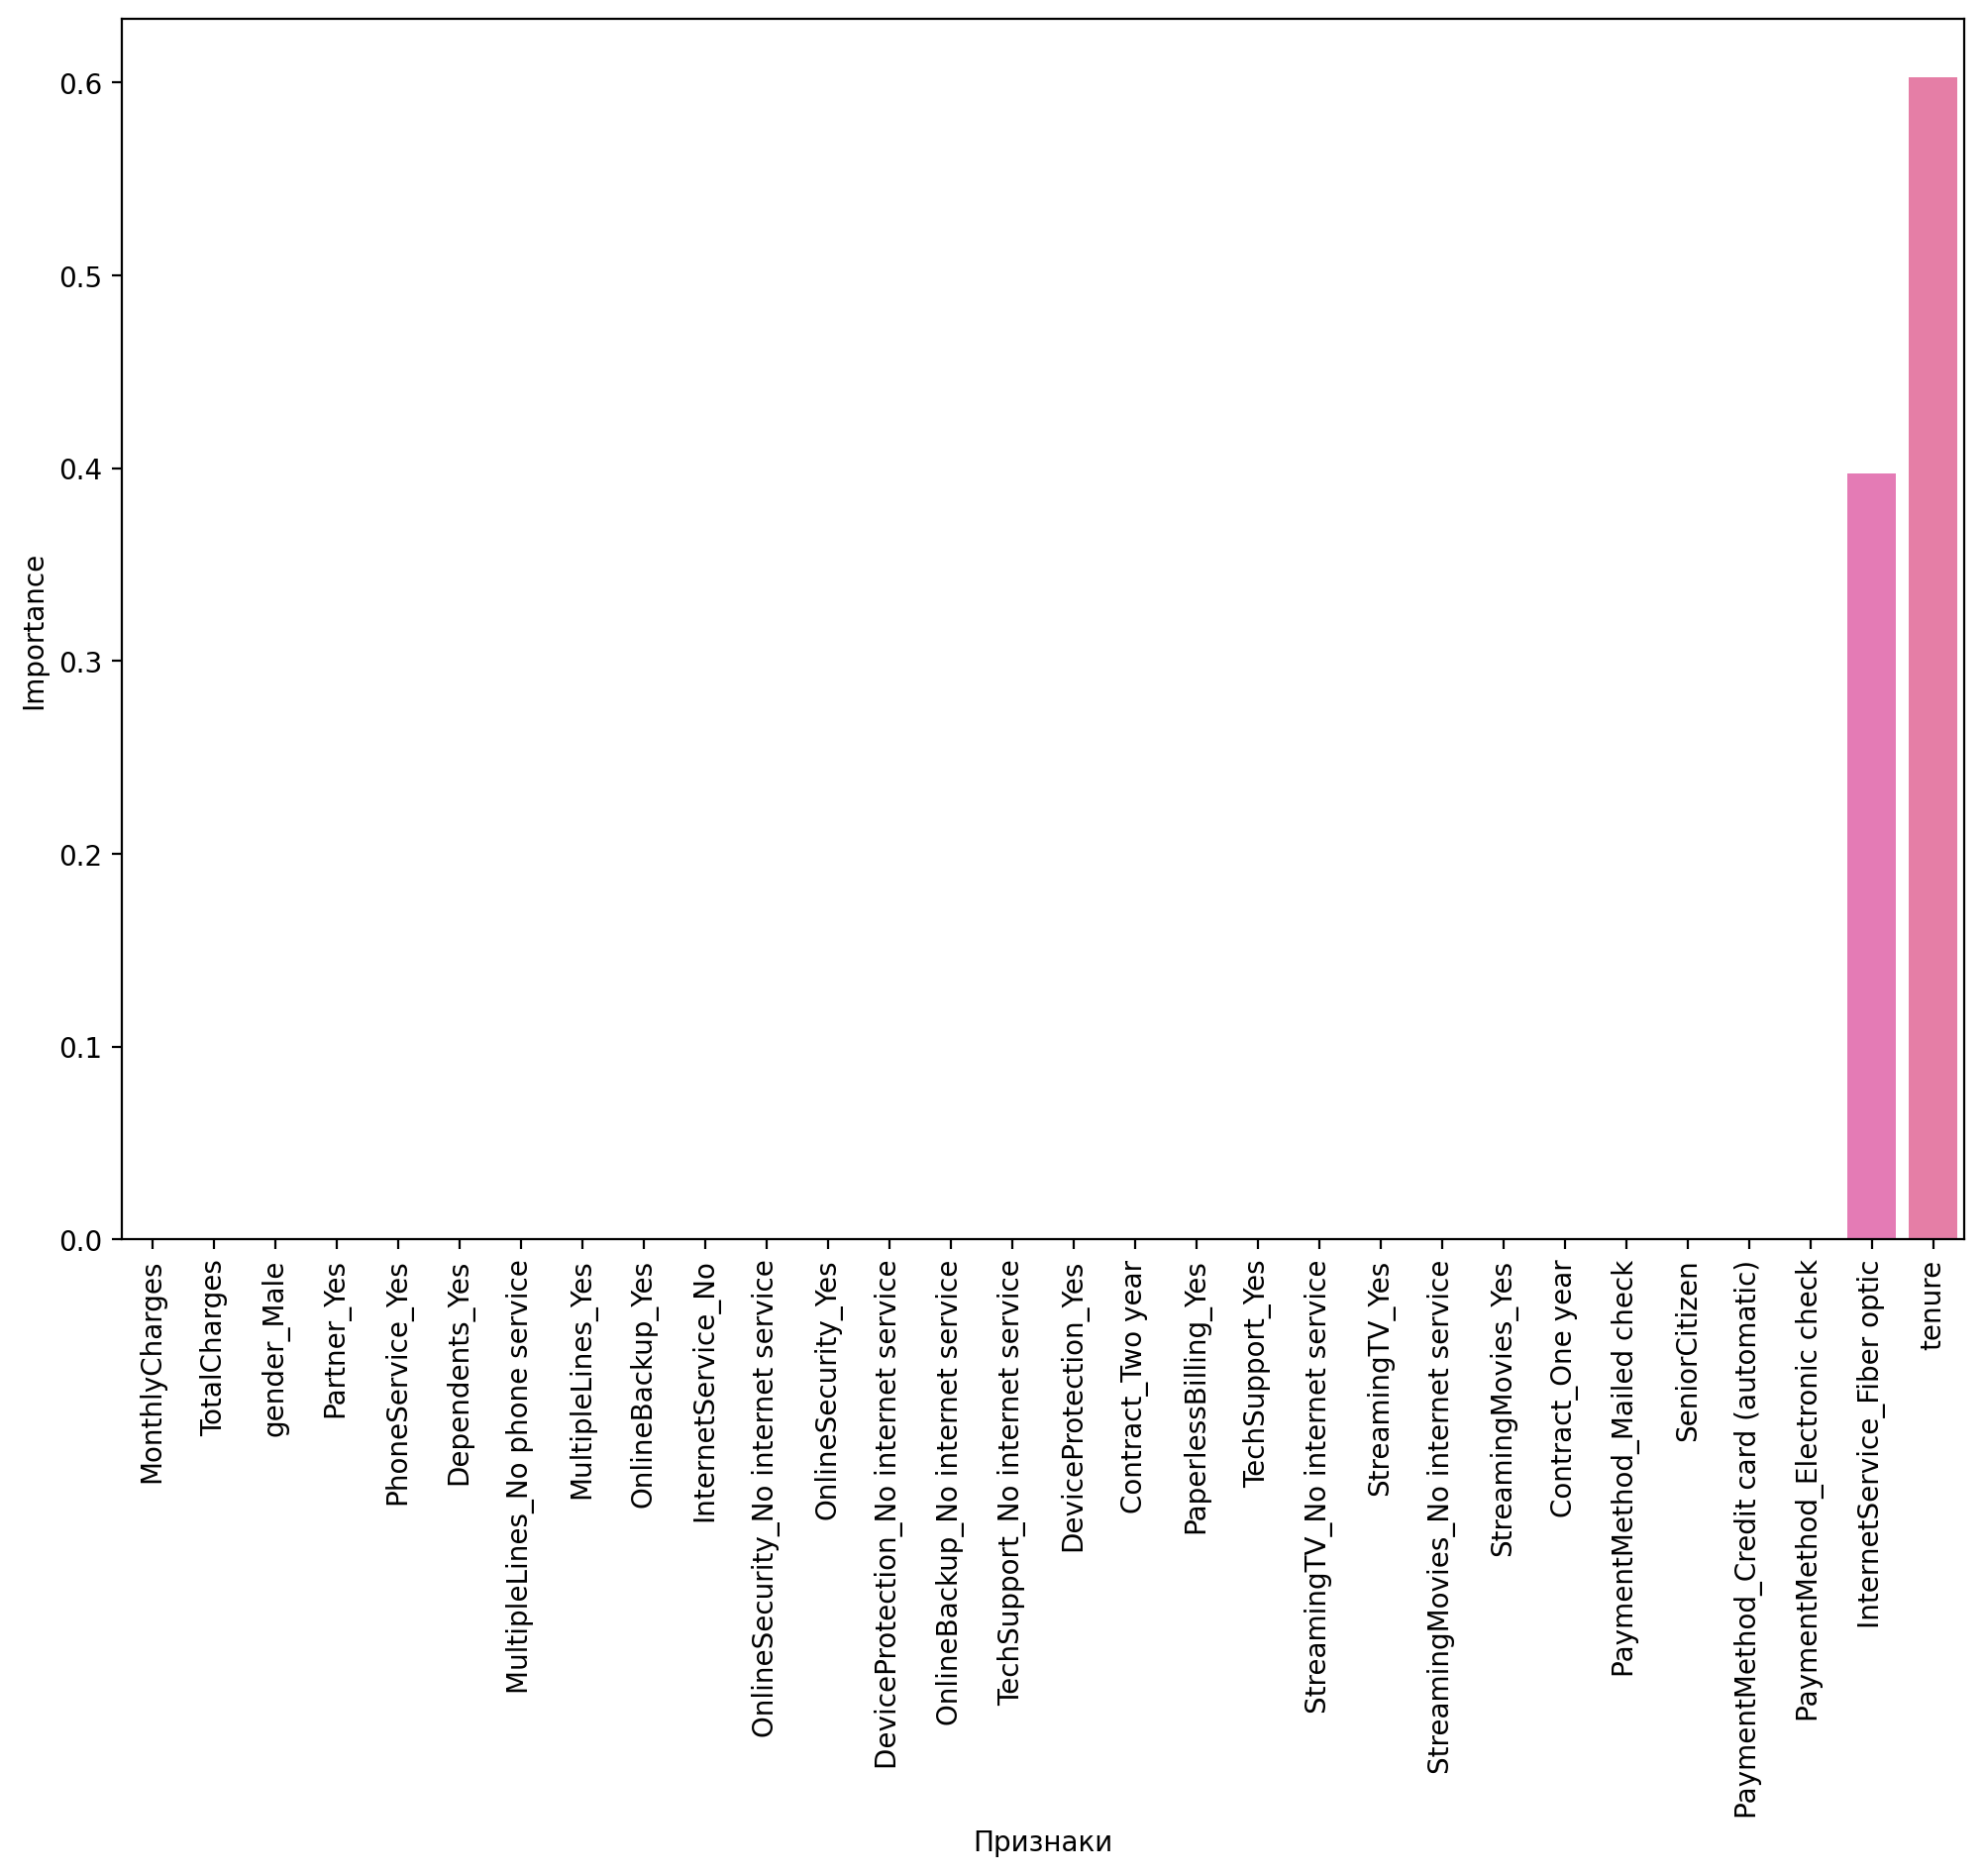

In [130]:
plt.figure(figsize=(12, 8), dpi=200)
sns.barplot(data=imp_feats, x=imp_feats.index, y='Importance', hue=imp_feats.index)
plt.xticks(rotation=90)
plt.xlabel('Признаки')
plt.show()

In [132]:
from sklearn.tree import plot_tree

In [144]:
tree_model = DecisionTreeClassifier(criterion='gini', max_depth=2, max_leaf_nodes=3)

In [148]:
tree_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2, max_leaf_nodes=3)

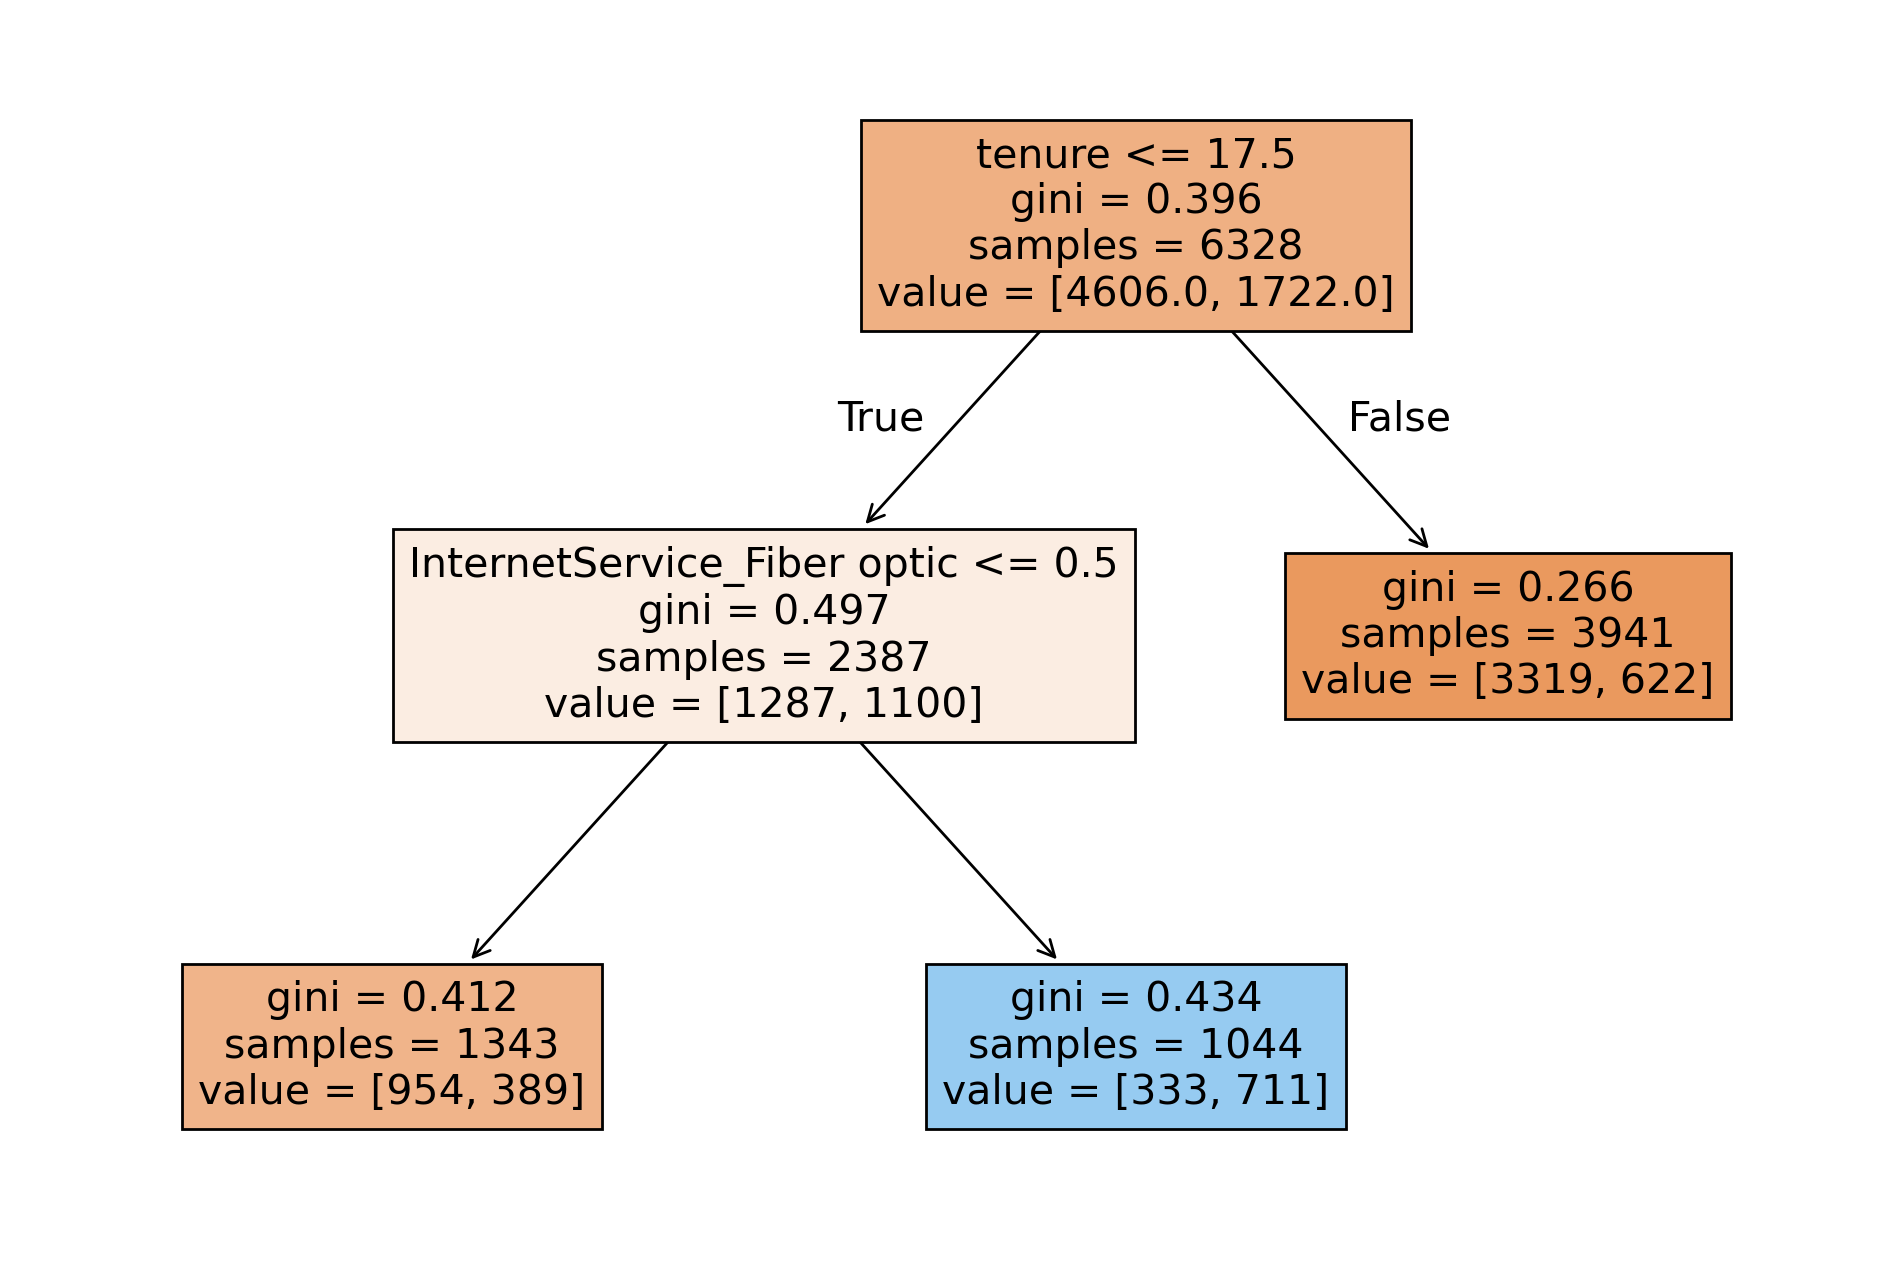

In [150]:
plt.figure(figsize=(12, 8), dpi=200)
plot_tree(tree_model, feature_names=X.columns, filled=True)
plt.show()

## Случайный лес (Random Forest)

**Создадим модель случайного леса, затем выведем отчёт "classification report" и матрицу ошибок для предсказанных результатов на тестовом наборе данных.**

In [152]:
from sklearn.ensemble import RandomForestClassifier

In [154]:
rfc_model = RandomForestClassifier()

In [162]:
param_rfc = {'n_estimators': [64, 100, 128, 200],
             'max_features': [2, 3, 4],
             'bootstrap': [True, False],
             'oob_score': [True, False]}

In [164]:
grid = GridSearchCV(rfc_model, param_grid=param_rfc)

In [166]:
grid.fit(X_train, y_train)

C:\Users\chern\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
60 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\chern\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\chern\anaconda3\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\chern\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py", line 448, in fit
    raise ValueError

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True, False], 'max_features': [2, 3, 4],
                         'n_estimators': [64, 100, 128, 200],
                         'oob_score': [True, False]})

In [168]:
preds_rfs = grid.predict(X_test)

In [170]:
print(classification_report(y_test, preds_rfs))

              precision    recall  f1-score   support

          No       0.86      0.89      0.87       557
         Yes       0.51      0.45      0.48       147

    accuracy                           0.79       704
   macro avg       0.68      0.67      0.67       704
weighted avg       0.79      0.79      0.79       704



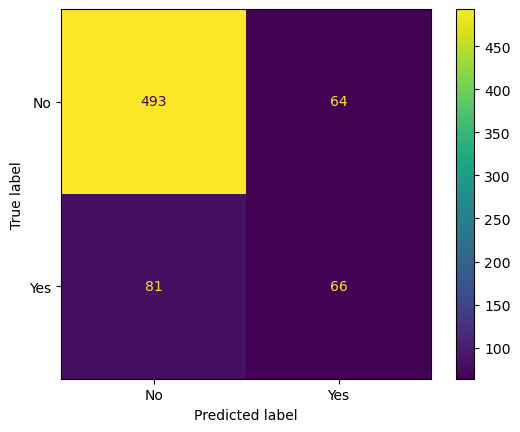

In [172]:
ConfusionMatrixDisplay.from_estimator(grid, X_test, y_test)

## Расширяемые деревья (Boosted Trees)

**Создадим модель Gradient Boosting, затем выведем отчёт "classification report" и матрицу ошибок для предсказанных результатов на тестовом наборе данных.**

In [174]:
from sklearn.ensemble import GradientBoostingClassifier

In [176]:
gbc_model = GradientBoostingClassifier()

In [178]:
param_gbc = {'n_estimators': [50, 100],
             'learning_rate': [0.1, 0.05, 0.2],
             'max_depth': [3, 4, 5]}

In [180]:
grid = GridSearchCV(gbc_model, param_grid=param_gbc)

In [182]:
grid.fit(X_test, y_test)

GridSearchCV(estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.1, 0.05, 0.2],
                         'max_depth': [3, 4, 5], 'n_estimators': [50, 100]})

In [184]:
preds_gbc = grid.predict(X_test)

In [188]:
print(classification_report(y_test, preds_gbc))

              precision    recall  f1-score   support

          No       0.89      0.99      0.93       557
         Yes       0.93      0.52      0.66       147

    accuracy                           0.89       704
   macro avg       0.91      0.75      0.80       704
weighted avg       0.89      0.89      0.88       704



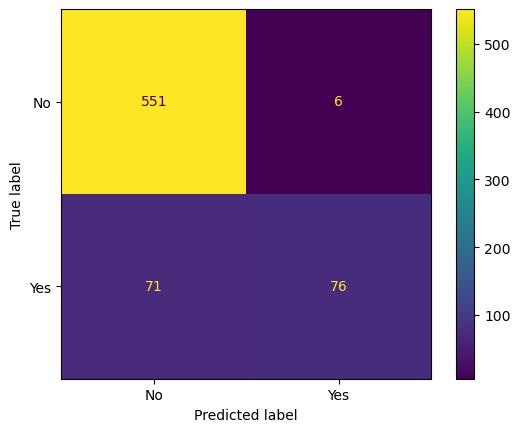

In [190]:
ConfusionMatrixDisplay.from_estimator(grid, X_test, y_test)

В целом модели показывали очень похожие результаты на этих данных.

---